In [1]:
%pip install transformers # Need to install transformers

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Needed to download CODI-gpt2 from huggingface for this notebook to work.
import os
from huggingface_hub import hf_hub_download

os.makedirs("CODI-gpt2", exist_ok=True)

path = hf_hub_download(
    repo_id="zen-E/CODI-gpt2",
    filename="pytorch_model.bin",
    local_dir="CODI-gpt2",
    local_dir_use_symlinks=False,
)
print("Downloaded to:", path)

/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Downloaded to: CODI-gpt2/pytorch_model.bin


In [1]:
import json
import random
from transformers import AutoTokenizer

def generate_uniform_length_dataset(num_examples=1000):
    """
    Generates a dataset where all questions for a given template have the
    exact same number of tokens. This is achieved by pre-selecting
    names, items, and numbers that are known to be single tokens.
    """
    # --- MODIFIED: Setup tokenizer at the start ---
    tokenizer = AutoTokenizer.from_pretrained("gpt2")

    def get_token_length(text):
        return len(tokenizer.encode(text, add_special_tokens=False))

    # --- MODIFIED: Filter all inputs to be single-token only ---
    print("Filtering inputs to ensure uniform token length...")

    names = ["Janet", "Tom", "Maria", "David", "Sarah"]
    one_token_names = [name for name in names if get_token_length(name) == 1]
    print(f"One-token names: {one_token_names}")

    items = ["apples", "books", "pencils", "cookies", "marbles"]
    one_token_items = [item for item in items if get_token_length(item) == 1]
    print(f"One-token items: {one_token_items}")

    single_digit_nums = [str(i) for i in range(10)]
    one_token_single_digits = [n for n in single_digit_nums if get_token_length(n) == 1]

    double_digit_nums = [str(i) for i in range(10, 100)]
    one_token_double_digits = [n for n in double_digit_nums if get_token_length(n) == 1]

    print(f"Found {len(one_token_double_digits)} two-digit numbers that are one token.")

    dataset = []
    templates = [
        {
            "template": "What is {A} + {B}?",
            "operation": "A+B",
            "answer_func": lambda a, b: a + b
        },
        {
            "template": "What is {A} * {B}?",
            "operation": "A*B",
            "answer_func": lambda a, b: a * b
        },
        {
            "template": "{name1} has {A} {item}s. {name2} has {B} more {item}s than {name1}. How many {item}s do they have in total?",
            "operation": "A+(A+B)",
            "answer_func": lambda a, b: a + (a + b)
        },
        {
            "template": "{name1} starts with {A} dollars. She buys {B} {item}s that cost {C} dollars each. How much money does she have left?",
            "operation": "A-(B*C)",
            "answer_func": lambda a, b, c: a - (b * c)
        }
    ]

    print("\nGenerating uniform-length dataset...")
    for i in range(num_examples):
        chosen_template = templates[i % len(templates)]
        question, answer = "", ""

        if "{C}" in chosen_template["template"]:
            a_str = random.choice(one_token_double_digits)
            b_str = random.choice(one_token_single_digits)
            c_str = random.choice(one_token_single_digits)

            question = chosen_template["template"].format(
                name1=random.choice(one_token_names),
                A=a_str, B=b_str, C=c_str,
                item=random.choice(one_token_items)
            )
            answer = str(chosen_template["answer_func"](int(a_str), int(b_str), int(c_str)))

        elif "{name1}" in chosen_template["template"]:
            a_str = random.choice(one_token_double_digits)
            b_str = random.choice(one_token_double_digits)

            name1 = random.choice(one_token_names)
            name2 = random.choice([n for n in one_token_names if n != name1])

            question = chosen_template["template"].format(
                name1=name1, name2=name2,
                A=a_str, B=b_str,
                item=random.choice(one_token_items)
            )
            answer = str(chosen_template["answer_func"](int(a_str), int(b_str)))
        else:
            a_str = random.choice(one_token_double_digits)
            b_str = random.choice(one_token_double_digits)
            question = chosen_template["template"].format(A=a_str, B=b_str)
            answer = str(chosen_template["answer_func"](int(a_str), int(b_str)))

        dataset.append({
            "question": question,
            "answer": answer,
            "template_type": chosen_template["operation"]
        })

    return dataset

# Generate 1000 examples
uniform_dataset = generate_uniform_length_dataset(1000)

# Save as a JSON Lines file
output_filename = 'gsm8k_uniform_length.jsonl'
with open(output_filename, 'w') as f:
    for entry in uniform_dataset:
        f.write(json.dumps(entry) + '\n')

print(f"\n✅ Generated uniform-length dataset: '{output_filename}'")
print("--> You can now re-run the data collection and analysis scripts on this file.")

/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Filtering inputs to ensure uniform token length...
One-token names: ['Tom', 'Maria', 'David', 'Sarah']
One-token items: ['books']
Found 90 two-digit numbers that are one token.

Generating uniform-length dataset...

✅ Generated uniform-length dataset: 'gsm8k_uniform_length.jsonl'
--> You can now re-run the data collection and analysis scripts on this file.


In [2]:
%pip install torch # Need to install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install peft

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
!{sys.executable} -m pip install -U datasets

In [4]:
import sys, torch
print("python:", sys.version)
print("python exe:", sys.executable)
print("torch:", torch.__version__)
print("torch file:", torch.__file__)
print("torch cuda built:", torch.backends.cuda.is_built())
print("torch cuda version:", torch.version.cuda)

python: 3.11.14 (main, Oct 10 2025, 08:54:04) [GCC 13.3.0]
python exe: /lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/bin/python
torch: 2.5.1
torch file: /lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/torch/__init__.py
torch cuda built: True
torch cuda version: 12.4


In [ ]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install --index-url https://download.pytorch.org/whl/cu124 torch torchvision torchaudio

In [5]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("torch cuda:", torch.version.cuda)
print("device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.5.1
cuda available: True
torch cuda: 12.4
device: NVIDIA GH200 480GB


In [1]:
import logging
import math
import re
import os
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence

import torch
import transformers
from torch.nn import functional as F
import json

from peft import PeftModel, LoraConfig, TaskType, get_peft_model
from datasets import load_dataset
from accelerate.utils import set_seed
from safetensors.torch import load_file

import numpy as np

from src.model import (
    CODI,
    ModelArguments,
    DataArguments as OriginalDataArguments, # <-- MODIFIED
    TrainingArguments,
)

@dataclass
class DataArguments(OriginalDataArguments):
    data_path: str = field(
        default=None, metadata={"help": "Path to the local training or evaluation file."}
    )

do_print = True
probe_topk = 5
probe_idx = None
test_attention = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Global list to store attention weights captured by hooks for a single step
captured_attentions = []

def get_attention_hook(module, input, output):
    """Captures the full attention weight tensor from a model's attention layer."""
    if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
        attention_weights = output[1].clone().detach().cpu()
        captured_attentions.append(attention_weights)

def evaluation(model_args, data_args, training_args):
    if model_args.lora_init:
        task_type = TaskType.CAUSAL_LM
        if any(name in model_args.model_name_or_path.lower() for name in ["llama", "mistral", "falcon", "qwen"]):
            target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"]
        elif any(name in model_args.model_name_or_path.lower() for name in ["phi"]):
            target_modules = ["q_proj", "k_proj", "v_proj", "dense", "fc1", "fc2"]
        elif any(name in model_args.model_name_or_path.lower() for name in ["gpt2"]):
            target_modules = ["c_attn", "c_proj", 'c_fc']
        else:
            raise ValueError(f"Only support LLAMA, Mistral, Falcon, Phi-2, but got {model_args.model_name_or_path}.")
        lora_config = LoraConfig(
            task_type=task_type,
            inference_mode=False,
            r=model_args.lora_r,
            lora_alpha=model_args.lora_alpha,
            lora_dropout=0.1,
            target_modules=target_modules,
            init_lora_weights=True,
        )
    else:
        raise NotImplementedError

    model = CODI(model_args, training_args, lora_config)

    try:
        state_dict = load_file(os.path.join(model_args.ckpt_dir, "model.safetensors"))
    except Exception:
        state_dict = torch.load(os.path.join(model_args.ckpt_dir, "pytorch_model.bin"))
    model.load_state_dict(state_dict, strict=False)
    model.codi.tie_weights()

    for layer in model.codi.transformer.h:
        layer.attn.register_forward_hook(get_attention_hook)

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        token=model_args.token,
        model_max_length=training_args.model_max_length,
        padding_side="left",
        use_fast=False,
    )

    if tokenizer.pad_token_id is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = model.pad_token_id
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')

    model = model.to(device)
    model.to(torch.bfloat16)

    logging.warning("Loading Data from local file...")
    dataset = load_dataset("json", data_files=data_args.data_path)
    test_set = dataset['train']

    logging.warning("Formatting inputs...")
    question = [f"{ex['question'].strip().replace('  ', ' ')}" for ex in test_set]
    answer = [float(ex['answer'].replace(",", "")) for ex in test_set]
    template_types = [ex["template_type"] for ex in test_set]

    logging.warning("Tokenizing inputs...")
    eval_step = math.ceil(len(question) / data_args.batch_size)
    logging.warning(f"Total example: {len(question)} | eval batch size: {data_args.batch_size} | eval steps: {eval_step}")

    question_data = []
    for i in range(eval_step):
        start_idx = i * data_args.batch_size
        end_idx = (i + 1) * data_args.batch_size
        batch_questions = question[start_idx:end_idx]
        batch = tokenizer(batch_questions, return_tensors="pt", padding="longest")

        if training_args.remove_eos:
            bot_tensor = torch.tensor([model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 1)
        else:
            bot_tensor = torch.tensor([tokenizer.eos_token_id, model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 2)

        batch["input_ids"] = torch.cat((batch["input_ids"], bot_tensor), dim=1)
        batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_tensor)), dim=1)
        question_data.append(batch.to(device))

    model.eval()
    gen_kwargs = {"max_new_tokens": 256, "temperature": 0.1, "top_k": 40, "top_p": 0.95, "do_sample": True}

    ans_pred_list = []
    len_cot = []
    phase1_data_collection = []

    # Initialize a list to store attention tensors for each question
    all_question_attentions = []
    num_layers = model.codi.config.num_hidden_layers
    num_heads = model.codi.config.num_attention_heads
    max_seq_len = training_args.model_max_length
    num_latent_steps = training_args.inf_latent_iterations

    for step, batch in enumerate(question_data):
        batch_size = batch["input_ids"].size(0)

        # Create a temporary holder for the current batch's attention data
        # Shape: (batch_size, latent_steps, layers, heads, max_seq_len)
        batch_attention_holder = torch.zeros(
            batch_size, num_latent_steps, num_layers, num_heads, max_seq_len,
            dtype=torch.bfloat16, device='cpu'
        )

        batch_latent_data = [[] for _ in range(batch_size)]

        with torch.no_grad():
            outputs = model.codi(input_ids=batch["input_ids"], use_cache=True, output_hidden_states=True, past_key_values=None, attention_mask=batch["attention_mask"], output_attentions=True)
            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)

            if training_args.use_prj:
                latent_embd = model.prj(latent_embd)

            for i in range(training_args.inf_latent_iterations):
                global captured_attentions
                captured_attentions.clear()

                outputs = model.codi(inputs_embeds=latent_embd, use_cache=True, output_hidden_states=True, past_key_values=past_key_values, output_attentions=True)

                # Process attention weights without averaging them across the batch
                for layer_idx, layer_attention_weights in enumerate(captured_attentions):
                    squeezed_weights = layer_attention_weights.squeeze(2)
                    current_seq_len = squeezed_weights.shape[-1]
                    batch_attention_holder[:, i, layer_idx, :, :current_seq_len] = squeezed_weights.to(torch.bfloat16)

                past_key_values = outputs.past_key_values
                current_latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
                probs = torch.nn.functional.softmax(model.codi.lm_head(current_latent_embd), dim=-1)
                _, top5_indices = torch.topk(probs, k=probe_topk, dim=2)

                for b_idx in range(batch_size):
                    decoded_top5 = [tokenizer.decode(x) for x in top5_indices[b_idx, 0]]
                    batch_latent_data[b_idx].append({
                        "latent_token_index": i,
                        "latent_token_tensor": current_latent_embd[b_idx].clone().detach().cpu(),
                        "decoded_intermediate_output": decoded_top5
                    })

                latent_embd = current_latent_embd
                if training_args.use_prj:
                    latent_embd = model.prj(latent_embd)

            all_question_attentions.extend(list(torch.unbind(batch_attention_holder, dim=0)))

            # --- Final Answer Generation ---
            if training_args.remove_eos:
                eot_emb = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id], dtype=torch.long, device='cuda')).unsqueeze(0).to(device)
            else:
                eot_emb = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id, tokenizer.eos_token_id], dtype=torch.long, device='cuda')).unsqueeze(0).to(device)

            output = eot_emb.expand(batch_size, -1, -1)

            finished = torch.zeros(batch_size, dtype=torch.bool, device="cuda")
            pred_tokens = [[] for _ in range(batch_size)]

            for _ in range(gen_kwargs["max_new_tokens"]):
                out = model.codi(inputs_embeds=output, use_cache=True, past_key_values=past_key_values, output_attentions=False)
                past_key_values = out.past_key_values
                logits = out.logits[:, -1, :model.codi.config.vocab_size-1]

                if training_args.greedy:
                    next_token_ids = torch.argmax(logits, dim=-1)
                else:
                    probs = F.softmax(logits / gen_kwargs["temperature"], dim=-1)
                    next_token_ids = torch.multinomial(probs, num_samples=1).squeeze(-1)

                for b in range(batch_size):
                    if not finished[b]:
                        token_id = next_token_ids[b].item()
                        pred_tokens[b].append(token_id)
                        if token_id == tokenizer.eos_token_id:
                            finished[b] = True

                if finished.all():
                    break

                output = model.get_embd(model.codi, model.model_name)(next_token_ids).unsqueeze(1)

            for mini_step, pred_token in enumerate(pred_tokens):
                len_cot.append(len(pred_token))
                decoded_pred = tokenizer.decode(pred_token, skip_special_tokens=True)

                current_question_idx = step * data_args.batch_size + mini_step
                pred_answer = extract_answer_number(decoded_pred)
                ans_pred_list.append(pred_answer)

                phase1_data_collection.append({
                    "question_id": current_question_idx,
                    "question_text": question[current_question_idx],
                    ## <-- MODIFIED: Save the template type instead of the COT
                    "template_type": template_types[current_question_idx],
                    "ground_truth_answer": answer[current_question_idx],
                    "model_prediction_text": decoded_pred,
                    "model_prediction_answer": pred_answer,
                    "latent_data": batch_latent_data[mini_step]
                })

    # Finalize and save the collected per-question attention data
    final_attention_tensor = torch.stack(all_question_attentions, dim=0)
    save_path = "per_question_attention_weights.pt"
    torch.save(final_attention_tensor, save_path)

    print("✅ Per-question analysis complete.")
    print(f"   Attention data saved to '{save_path}'")
    print(f"   Tensor shape: {final_attention_tensor.shape}")

    accuracy = compute_accuracy(answer, ans_pred_list)

    def convert_tensors_to_lists(data):
        if isinstance(data, list):
            return [convert_tensors_to_lists(item) for item in data]
        elif isinstance(data, dict):
            return {key: convert_tensors_to_lists(value) for key, value in data.items()}
        elif isinstance(data, torch.Tensor):
            return data.detach().cpu().tolist()
        else:
            return data

    with open("phase1_data_collection.json", "w") as f:
        serializable_data = convert_tensors_to_lists(phase1_data_collection)
        json.dump(serializable_data, f, indent=2)

    print(f"adapter: {model_args.adapter_name_or_path} | Synthetic dataset accuracy: {100*accuracy:.2f}% | ")
    print(f"average length of response: {sum(len_cot)/len(len_cot)}")

    return 100*accuracy

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    return float(pred[-1])

def compute_accuracy(gold: list, pred: list):
    acc = sum(p == g for p, g in zip(pred, gold))
    return acc / len(gold)

if __name__ == "__main__":
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    args = [
        "--data_path", "gsm8k_varied_complexity.jsonl",
        "--output_dir", "outputs/probe_latent_results",
        "--model_name_or_path", "gpt2",
        "--seed", "11",
        "--model_max_length", "512",
        "--bf16",
        "--lora_r", "128",
        "--lora_alpha", "32",
        "--lora_init",
        "--batch_size", "32",
        "--greedy", "True",
        "--num_latent", "6",
        "--use_prj", "True",
        "--prj_dim", "768",
        "--prj_no_ln", "False",
        "--prj_dropout", "0.0",
        "--inf_latent_iterations", "6",
        "--inf_num_iterations", "1",
        "--remove_eos", "True",
        "--use_lora", "True",
        "--ckpt_dir", "CODI-gpt2"
    ]
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)

    accu_list = []
    training_args.inf_num_iterations = 1
    for i in range(training_args.inf_num_iterations):
        accu = evaluation(model_args, data_args, training_args)
        accu_list.append(accu)
    print(f"Average accuracy over {training_args.inf_num_iterations} sampling: {sum(accu_list)/len(accu_list)}")

/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


cuda


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 1525.94it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/tmp/ipykernel_8483/3432627389.py:78: FutureWarning: You are using `torch.load` with `we

trainable params: 20057088 || all params: 144499200 || trainable%: 13.880414562848792


FileNotFoundError: Unable to find '/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/gsm8k_varied_complexity.jsonl'

In [7]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Loading and processing data from the UNIFORM-LENGTH run...


/tmp/ipykernel_6344/2046719639.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_tensor = torch.load(ATTENTION_TENSOR_PATH)



--- Generating Head-by-Head Heatmaps for Layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] ---
  Visualizing all 12 heads in Layer 1...


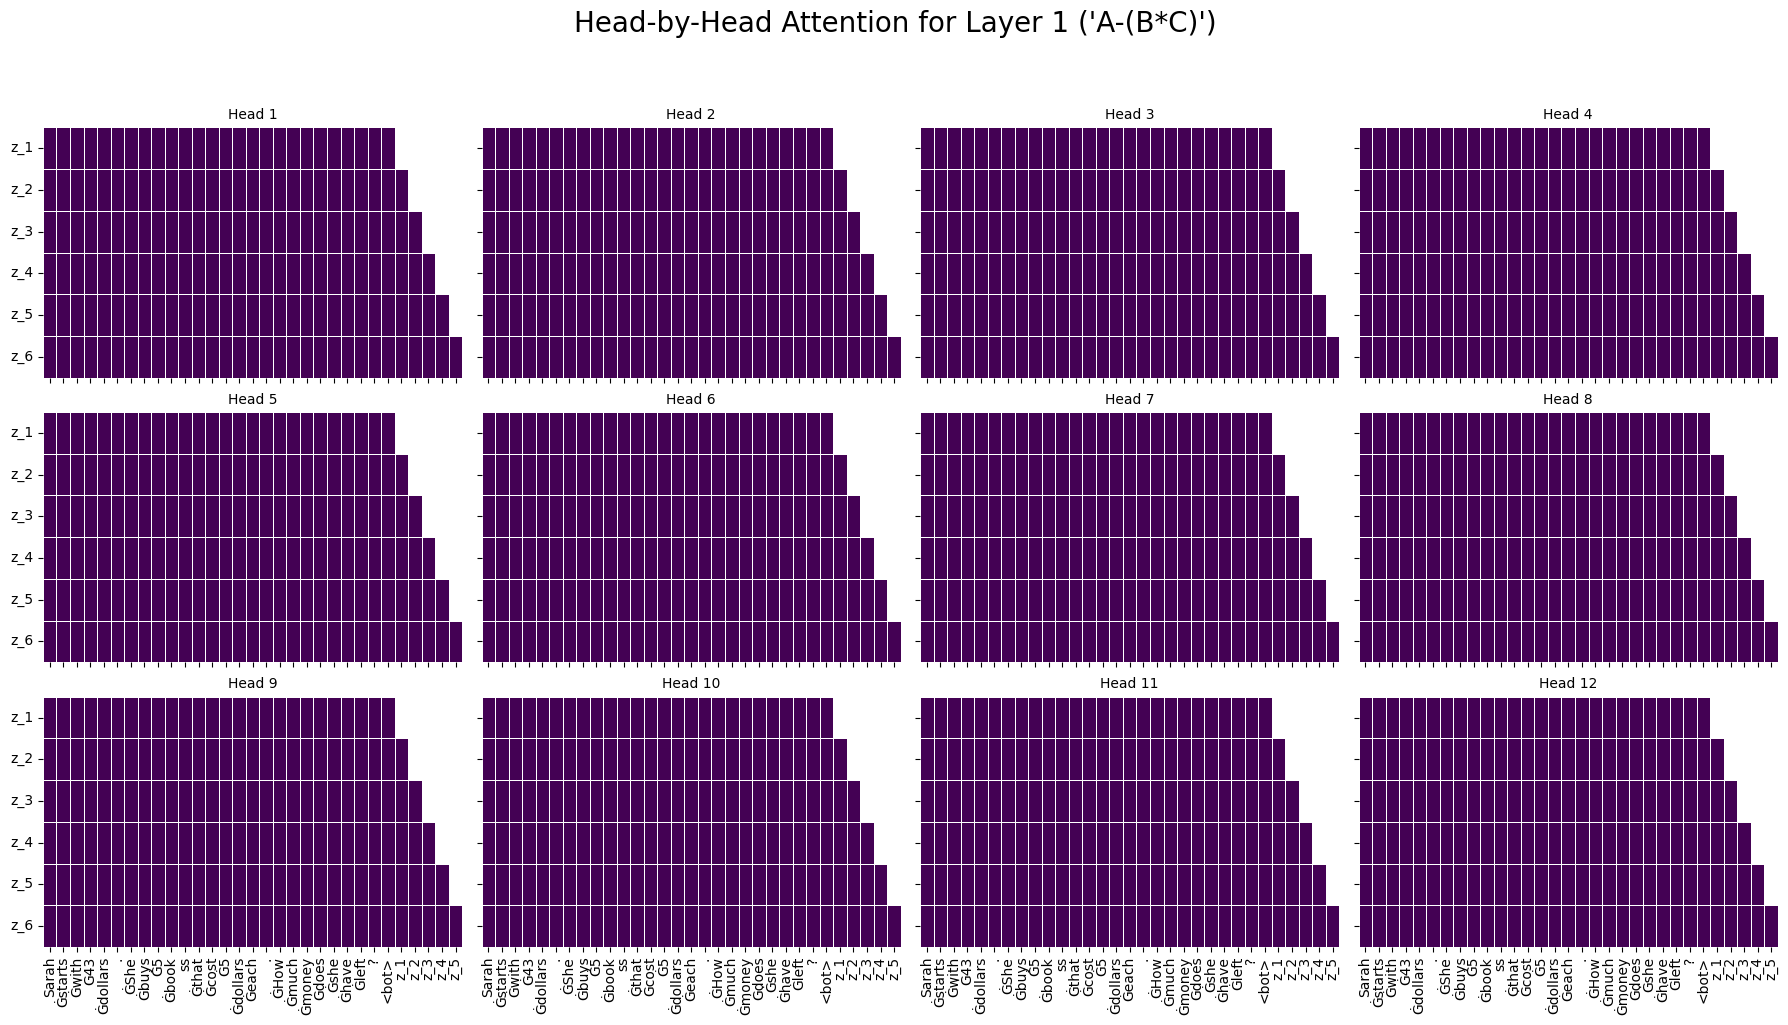

  Visualizing all 12 heads in Layer 2...


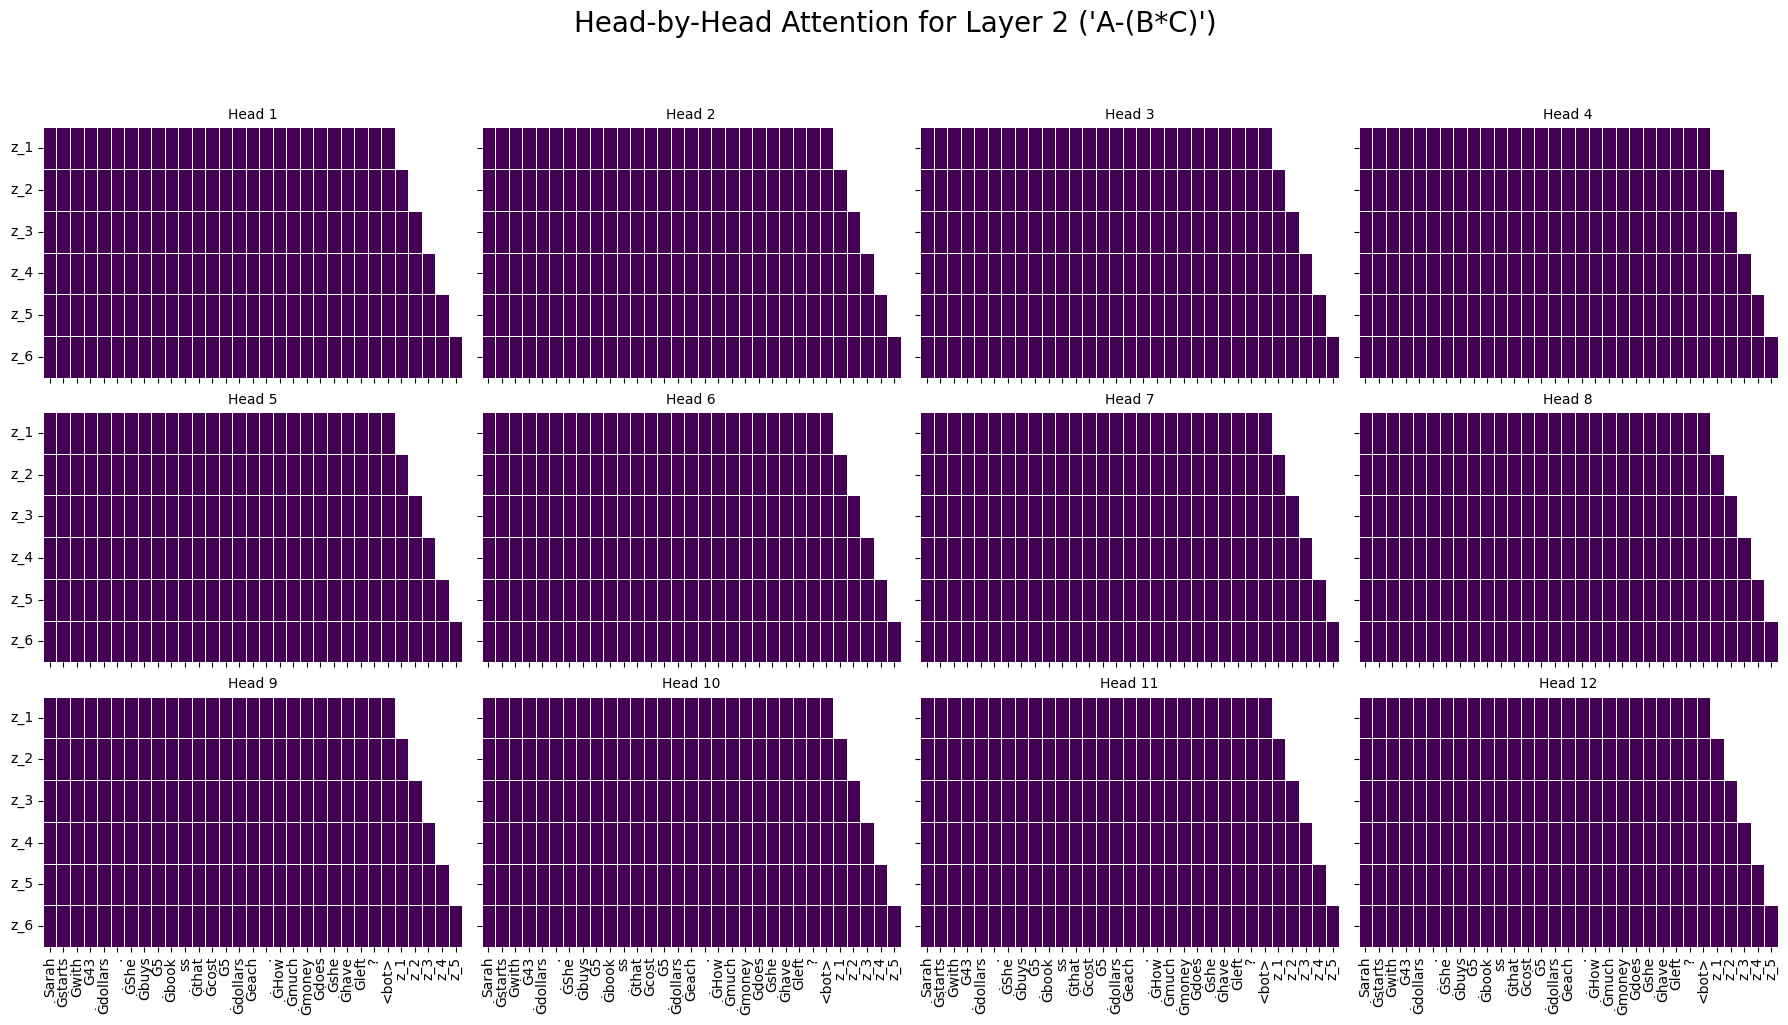

  Visualizing all 12 heads in Layer 3...


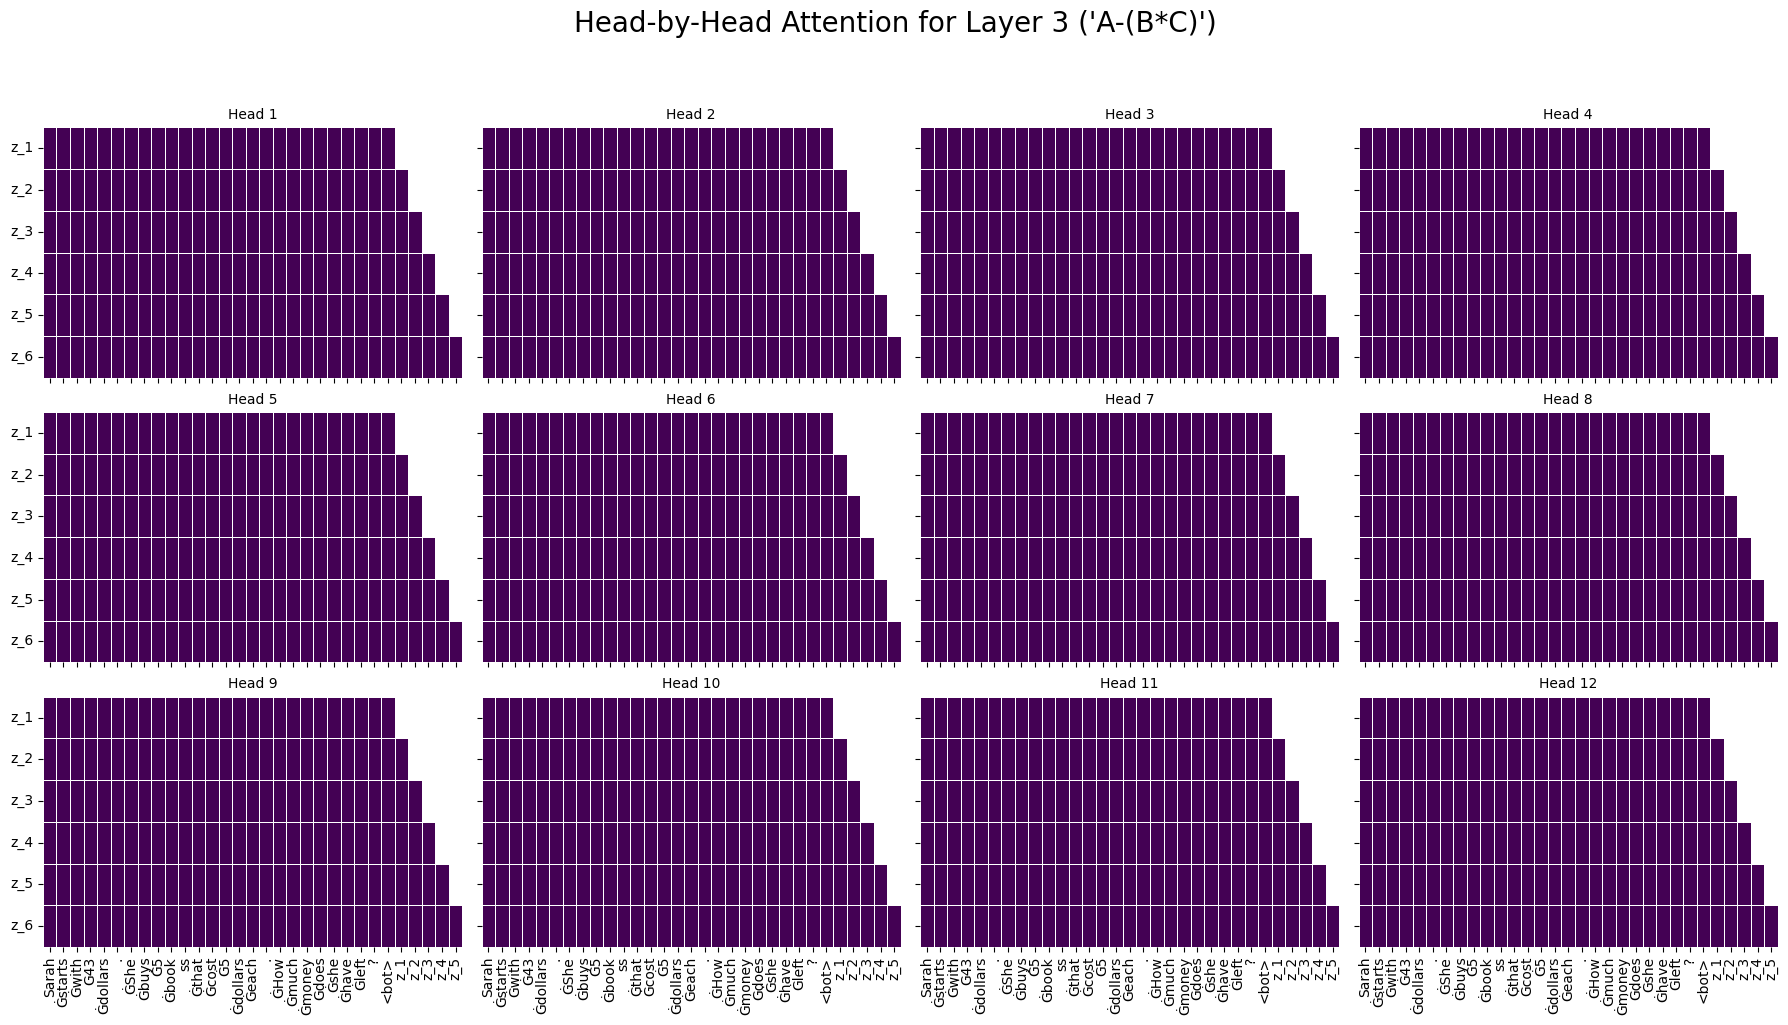

  Visualizing all 12 heads in Layer 4...


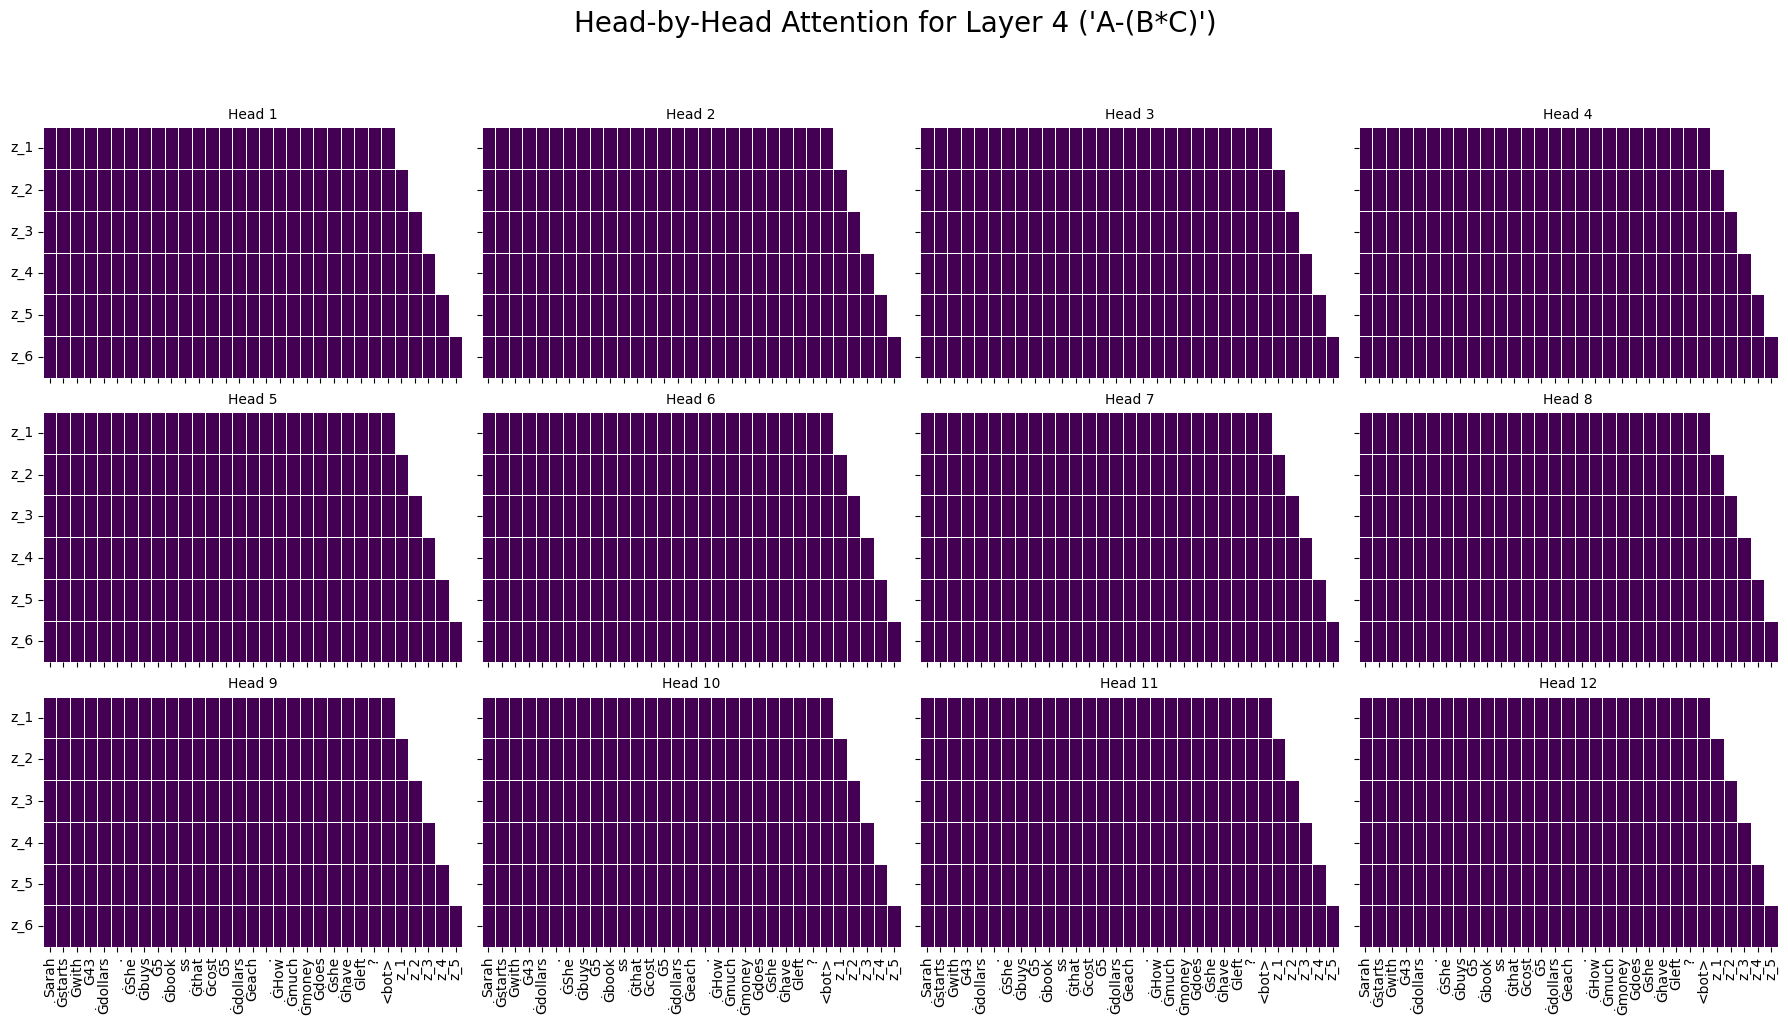

  Visualizing all 12 heads in Layer 5...


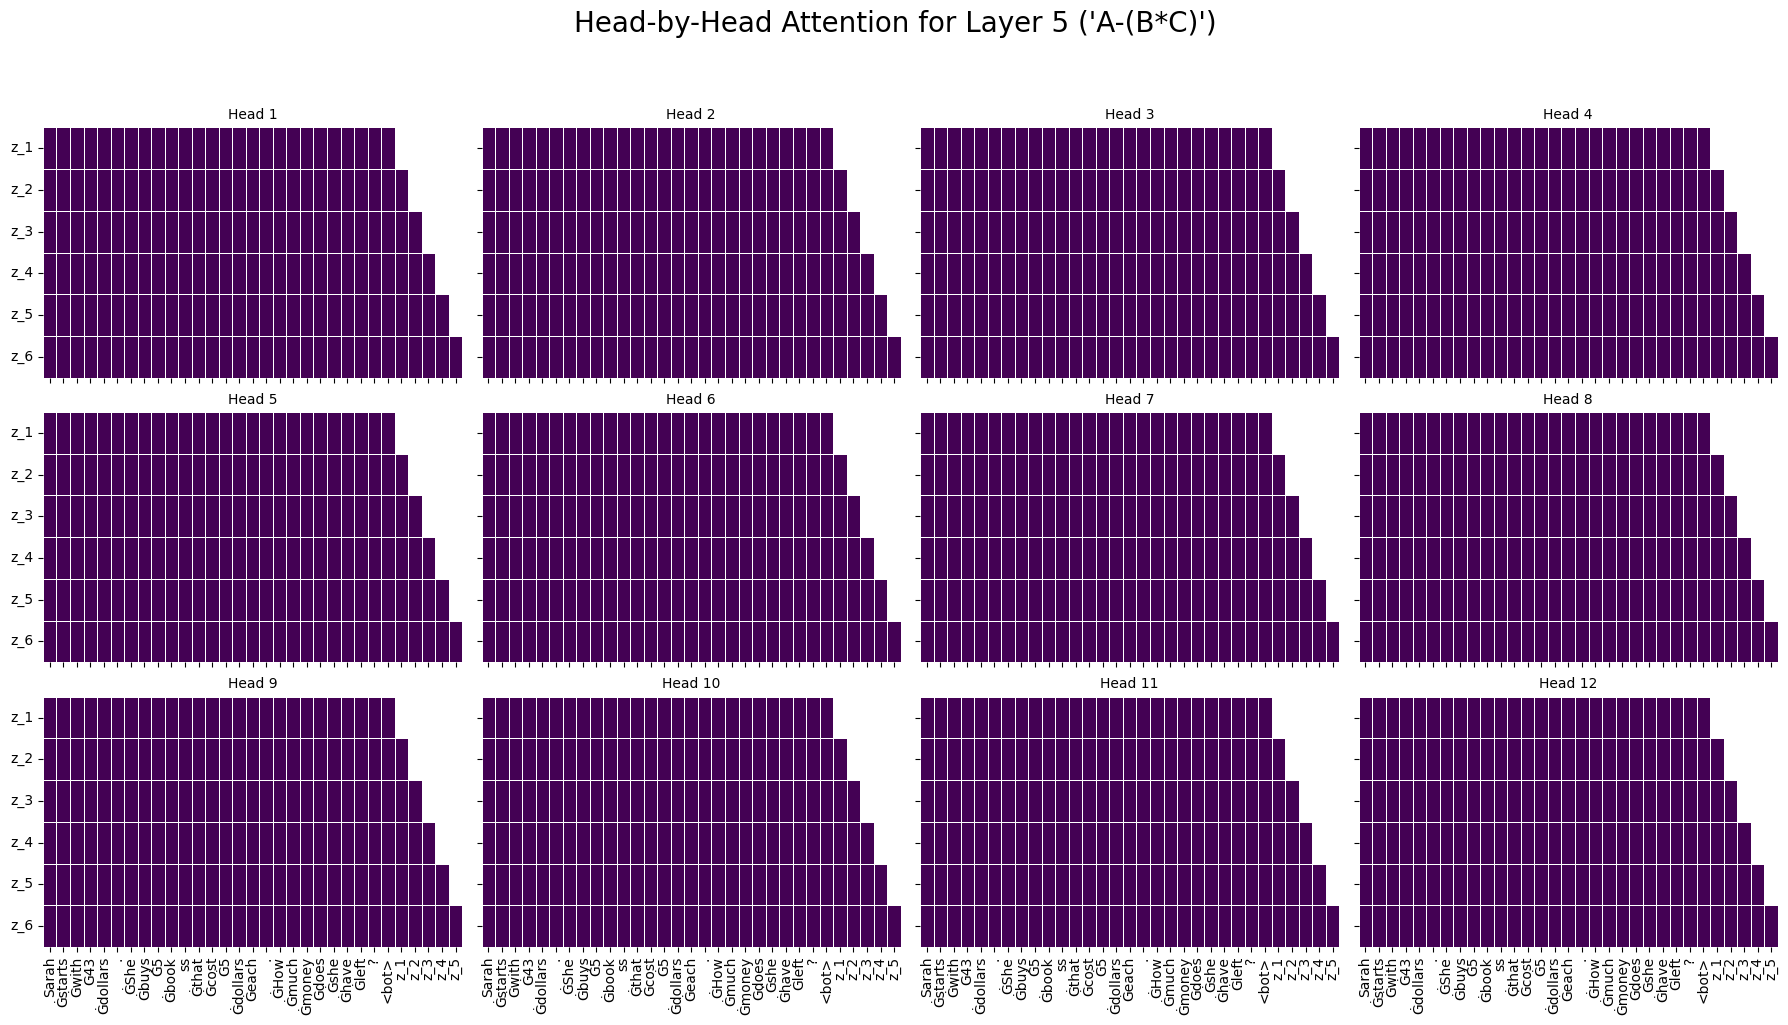

  Visualizing all 12 heads in Layer 6...


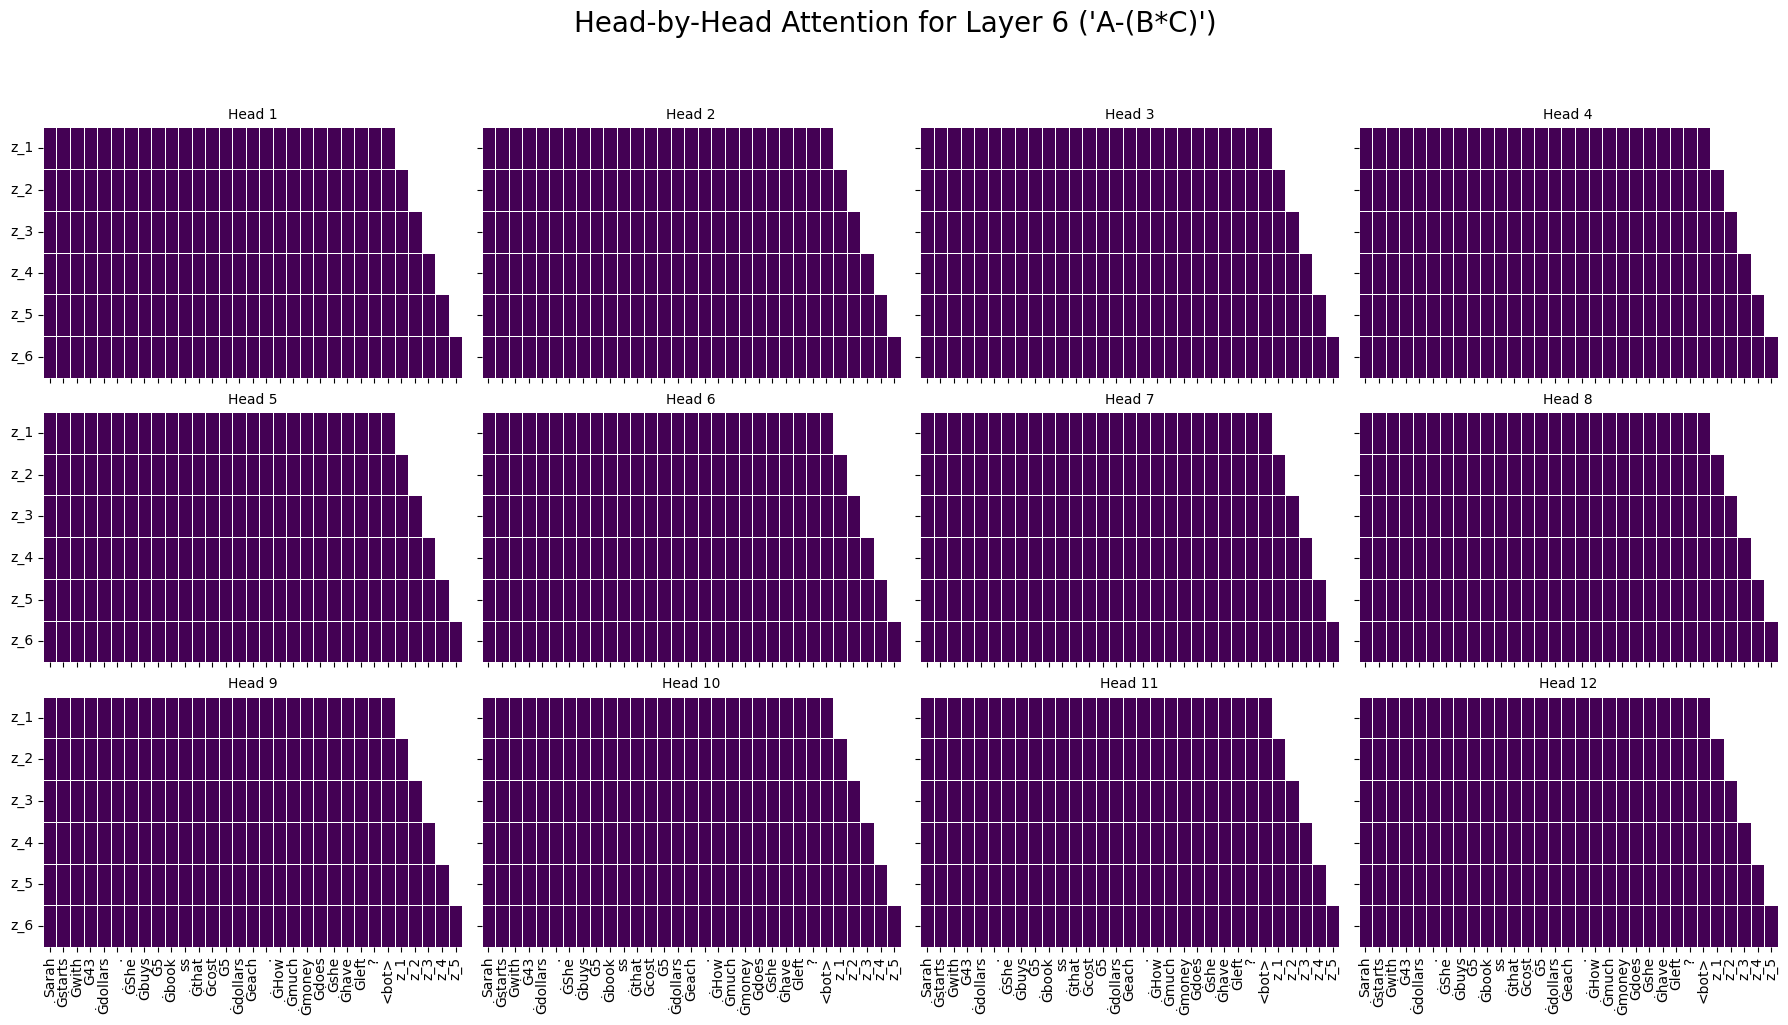

  Visualizing all 12 heads in Layer 7...


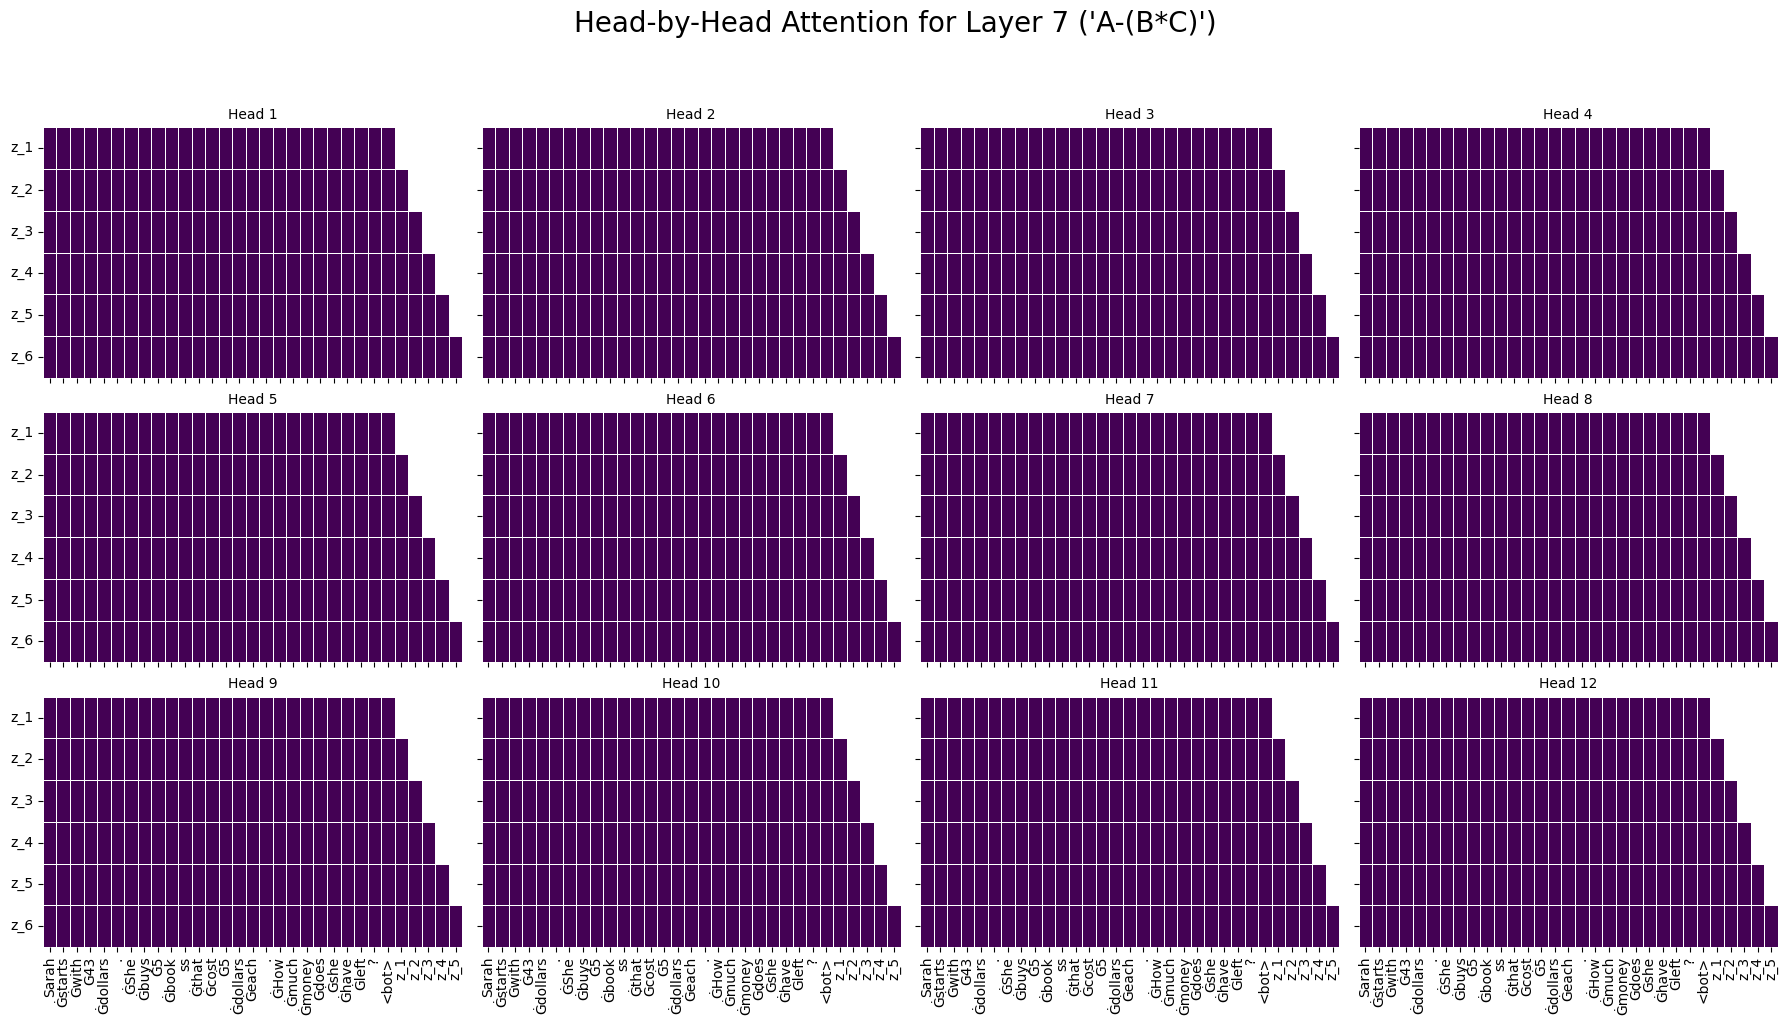

  Visualizing all 12 heads in Layer 8...


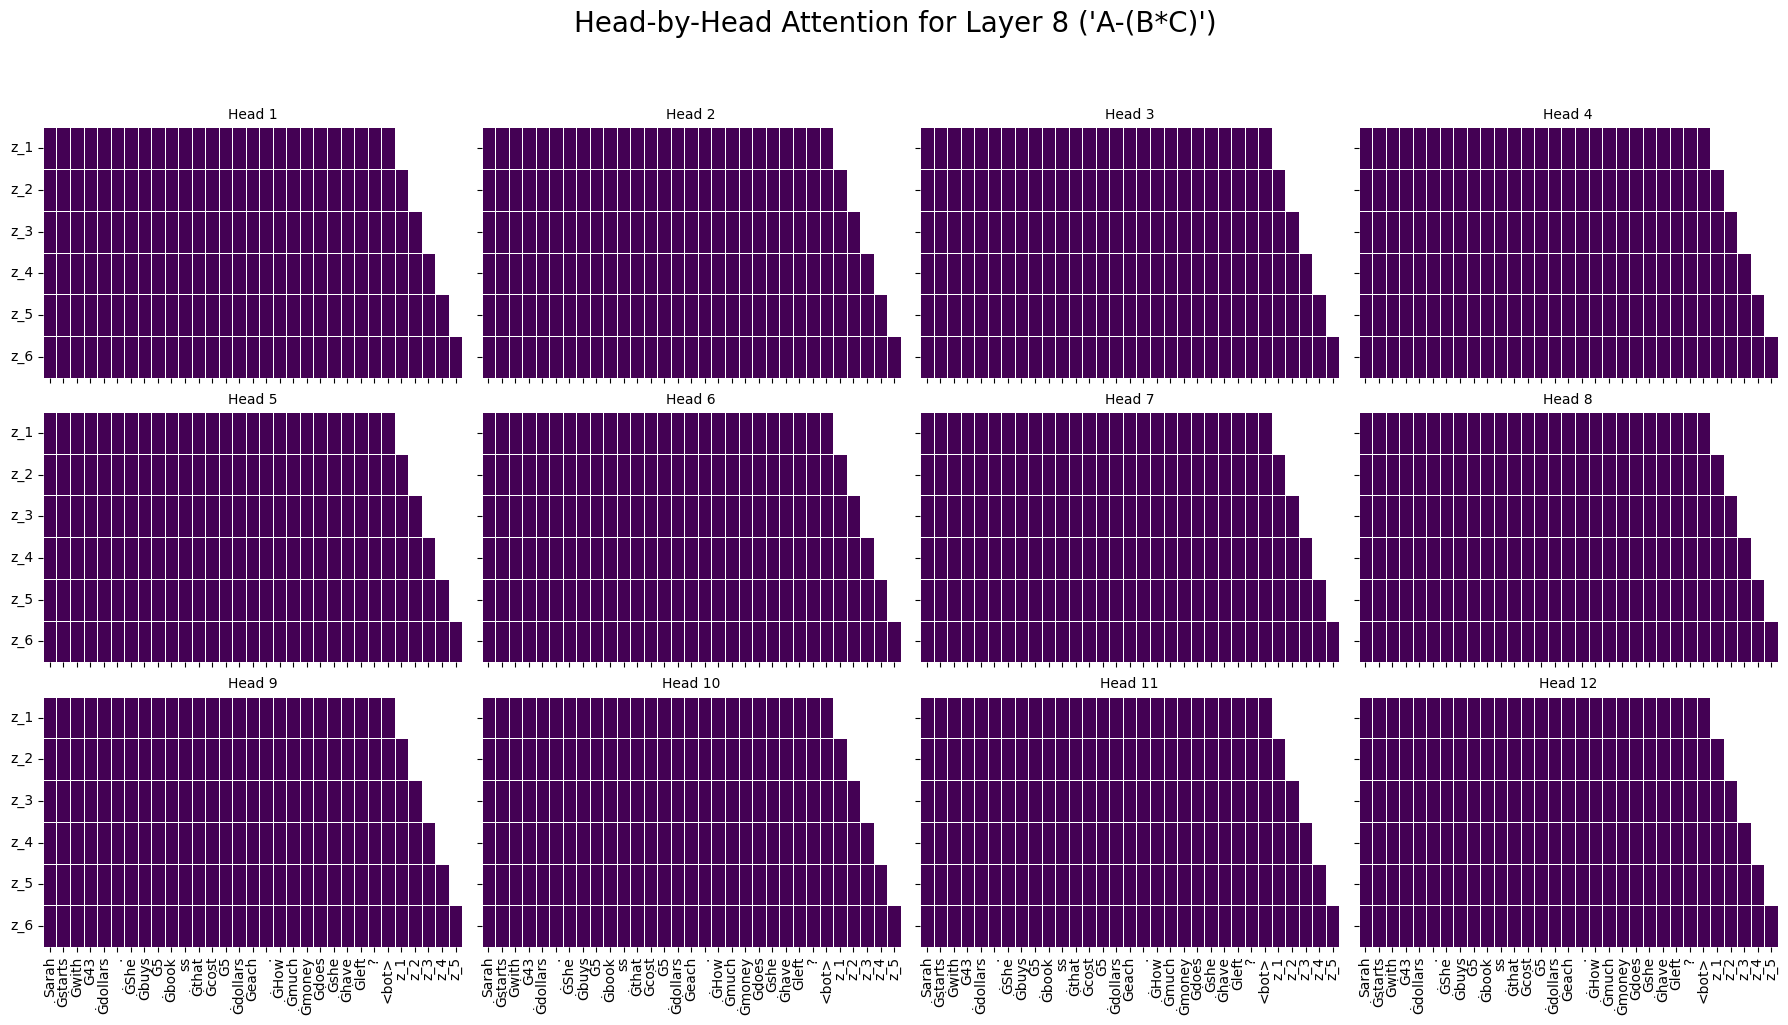

  Visualizing all 12 heads in Layer 9...


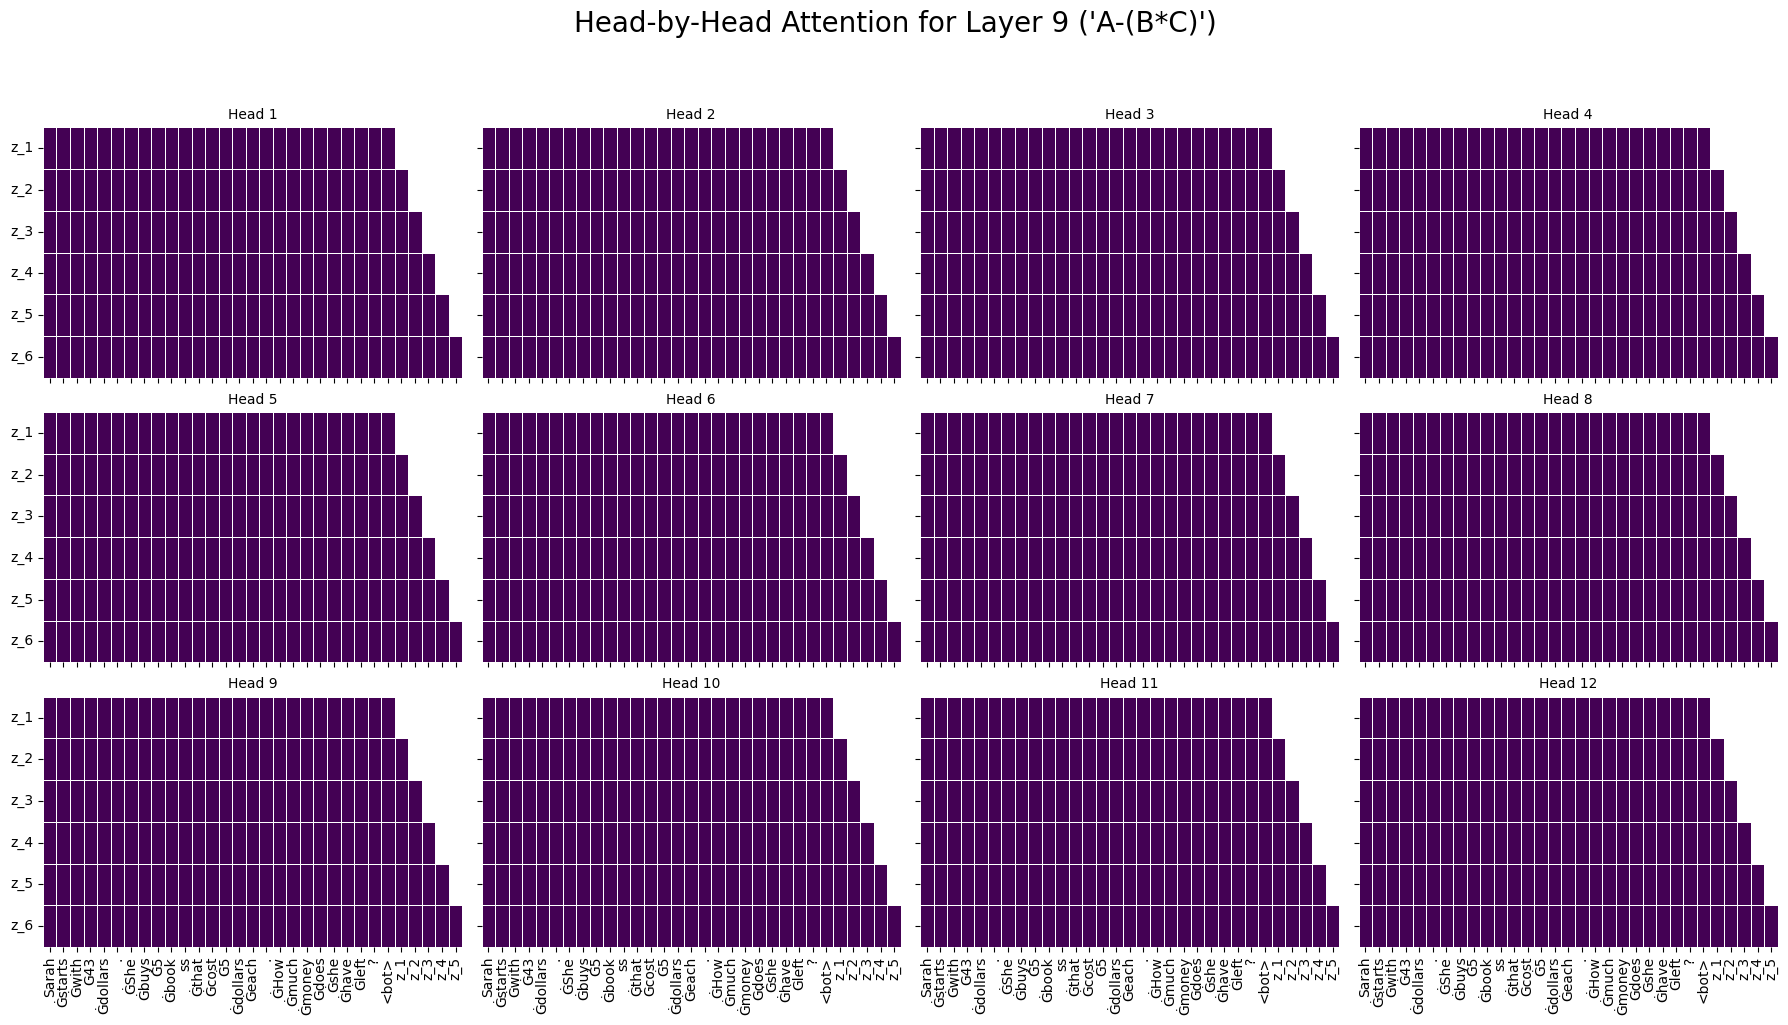

  Visualizing all 12 heads in Layer 10...


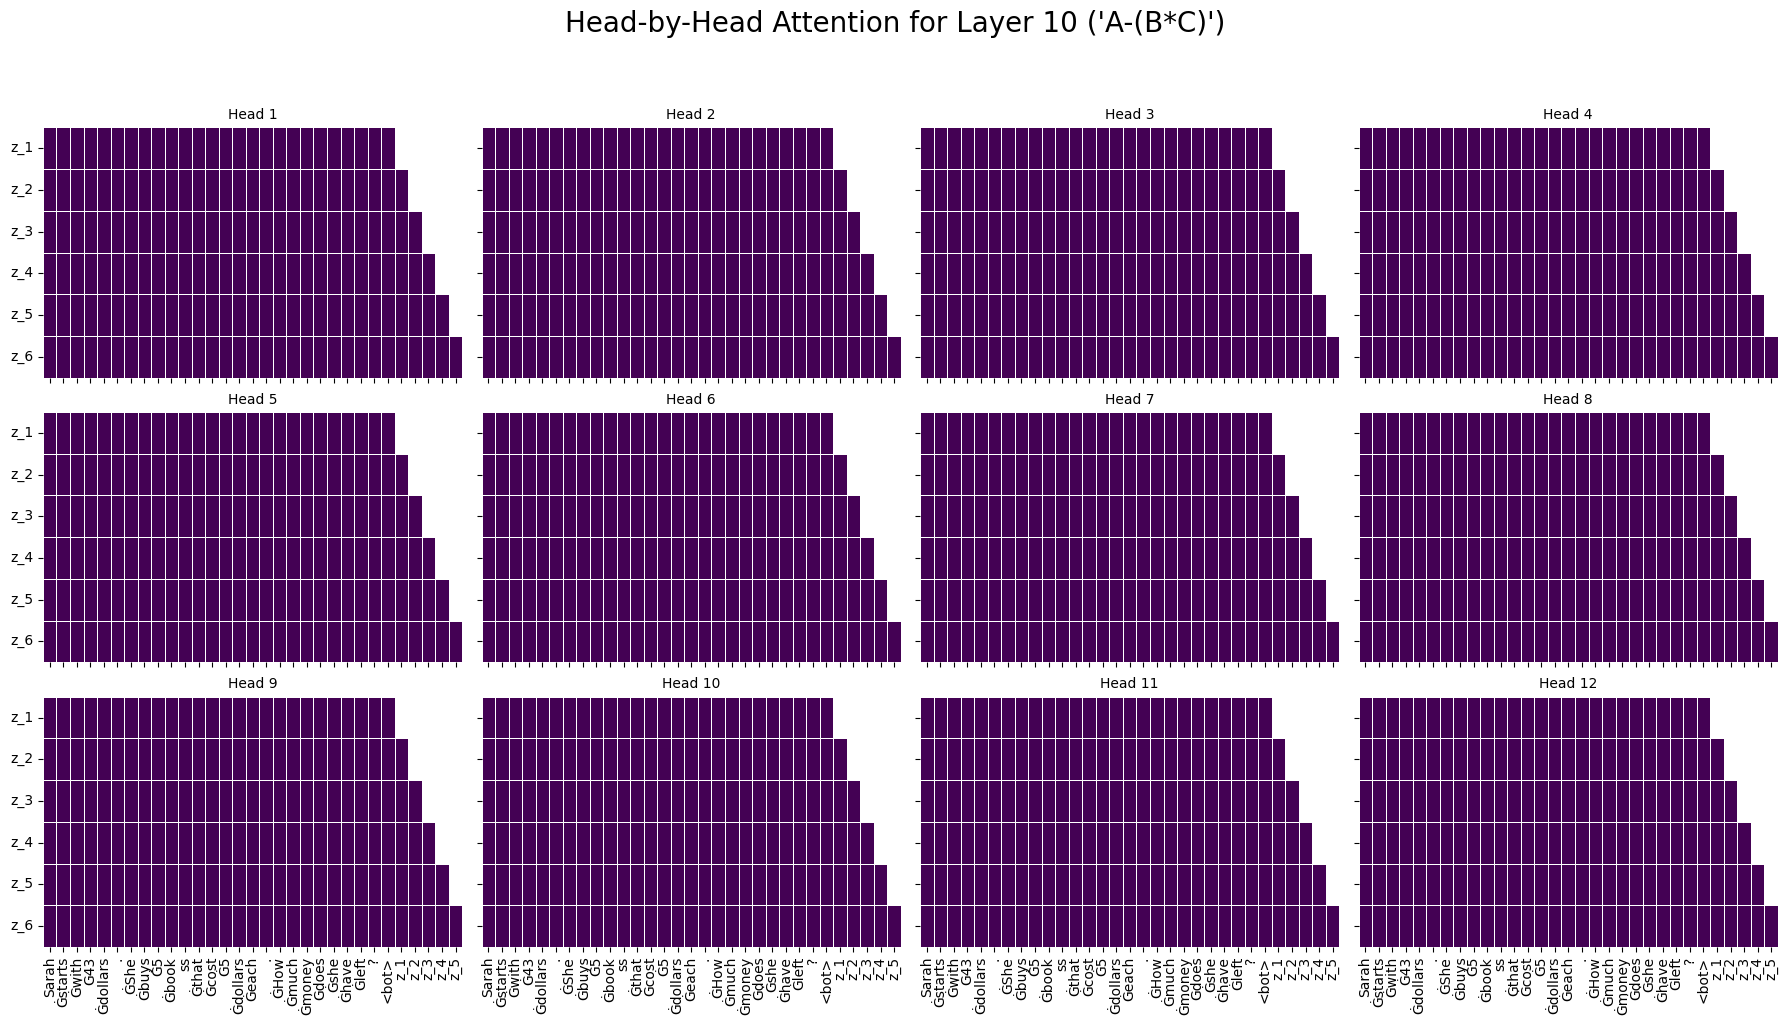

  Visualizing all 12 heads in Layer 11...


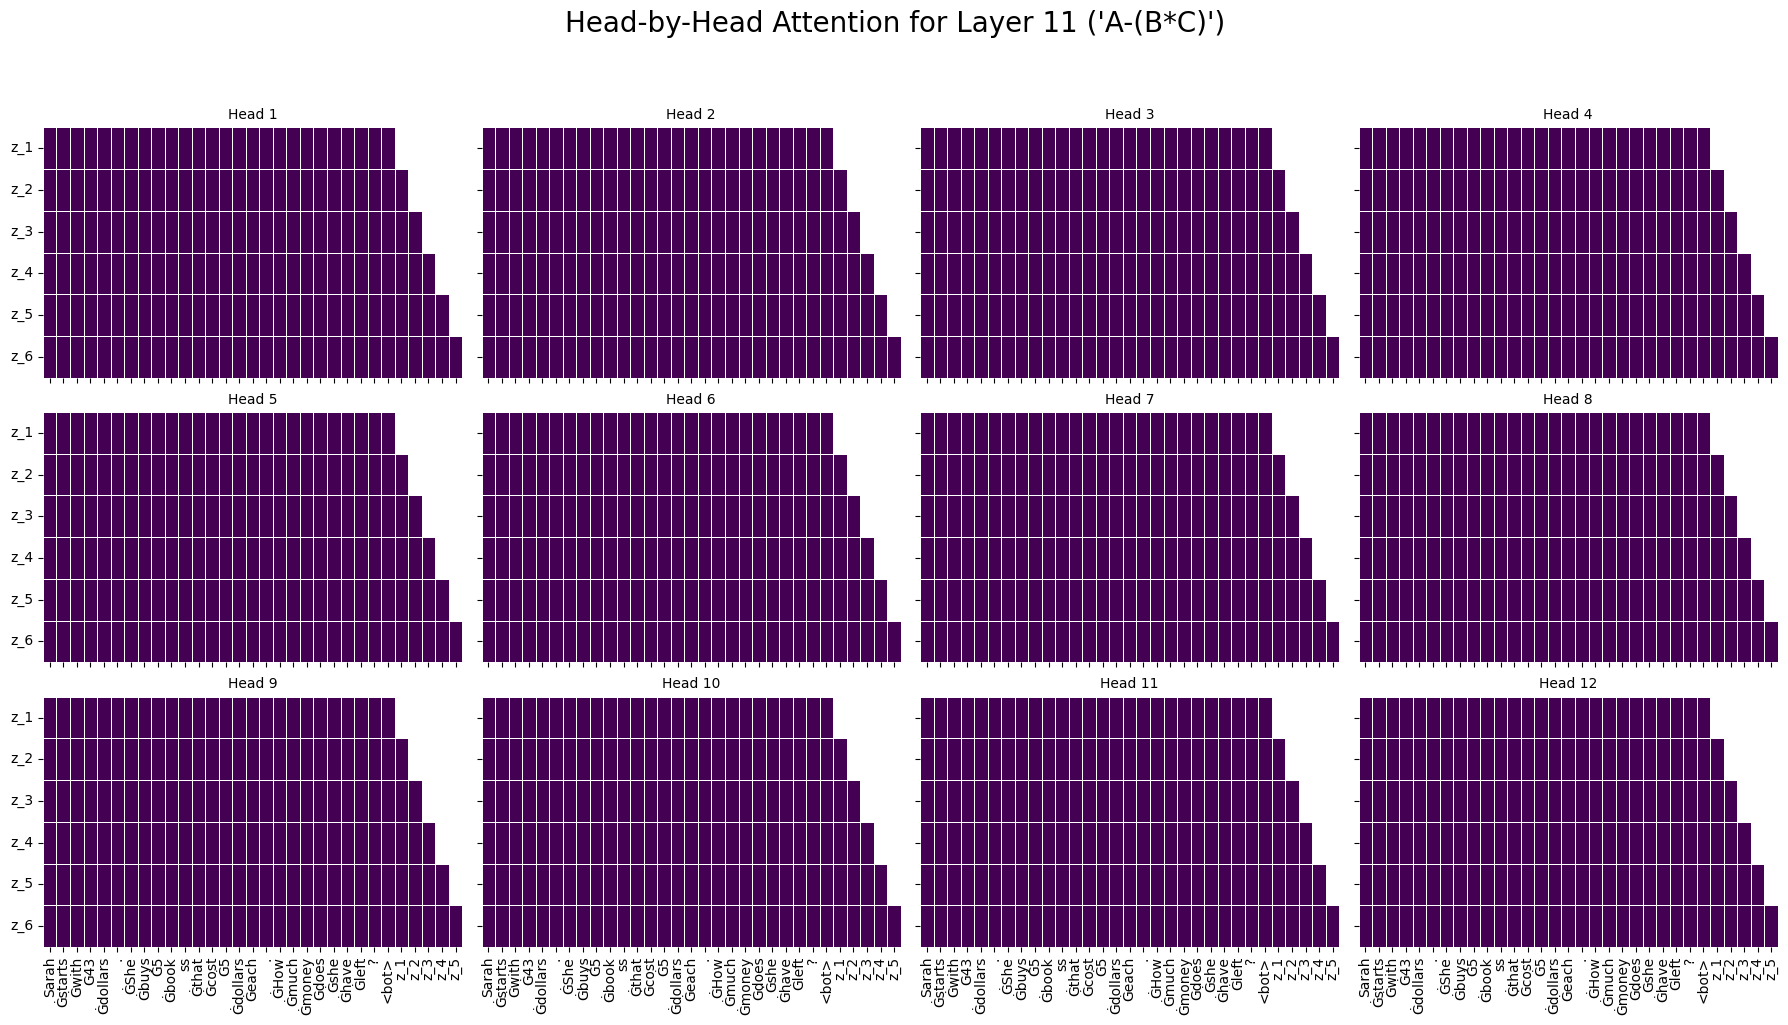

  Visualizing all 12 heads in Layer 12...


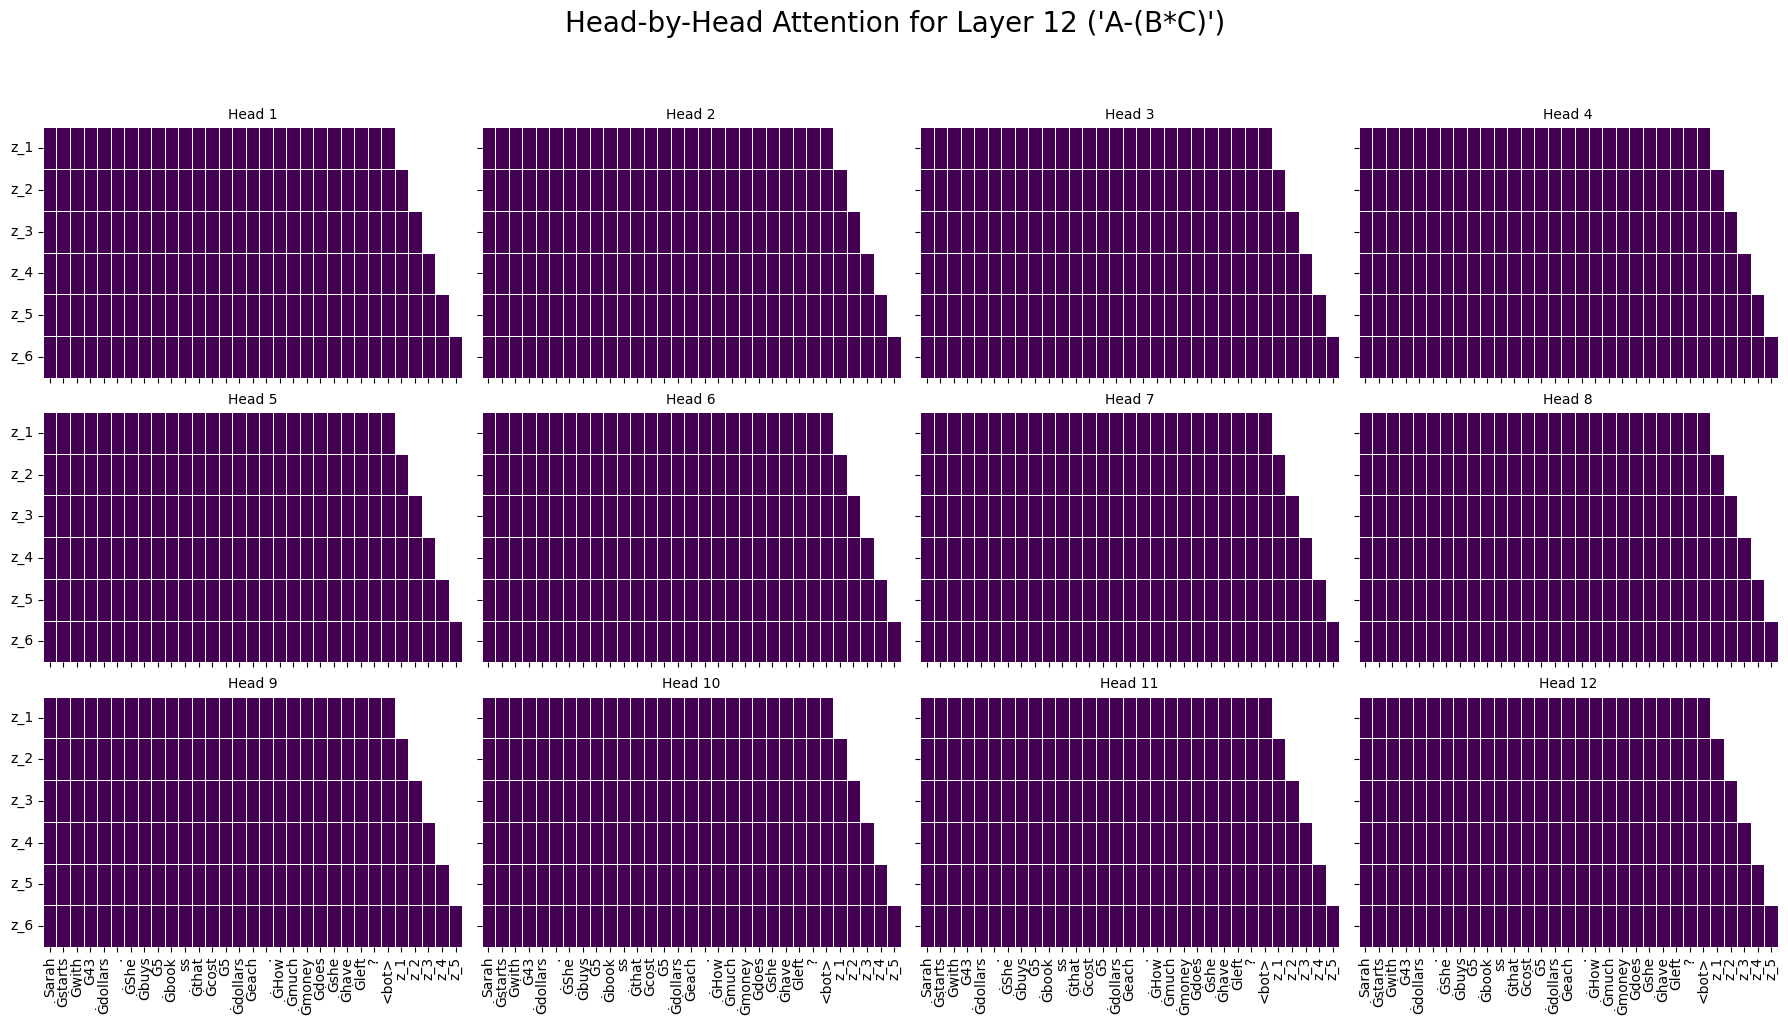

In [10]:
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# --- Configuration ---
ATTENTION_TENSOR_PATH = "per_question_attention_weights.pt"
METADATA_PATH = "gsm8k_uniform_length.jsonl"
MODEL_NAME = "gpt2"
TEMPLATE_TO_ANALYZE = "A-(B*C)"
LAYERS_TO_ANALYZE = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# --- 1. Load and Process Data ---
print("Loading and processing data from the UNIFORM-LENGTH run...")
try:
    attention_tensor = torch.load(ATTENTION_TENSOR_PATH)
    df = pd.read_json(METADATA_PATH, lines=True)
except FileNotFoundError as e:
    print(f"❌ Error: Make sure data files are present and from the uniform-length run.")
    exit()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- 2. Filter for the "A+B" Template ---
template_df = df[df['template_type'] == TEMPLATE_TO_ANALYZE]
if template_df.empty:
    print(f"No questions found for template type {TEMPLATE_TO_ANALYZE}. Exiting.")
    exit()

template_indices = template_df.index
template_attn = attention_tensor[template_indices]

# --- 3. Prepare Static Data for Plotting ---
representative_question = template_df.iloc[0]['question']
token_ids = tokenizer.encode(representative_question)
question_token_strings = tokenizer.convert_ids_to_tokens(token_ids) + ['<bot>']
num_question_tokens = len(question_token_strings)

num_latent_steps = template_attn.shape[1]
num_heads = template_attn.shape[3]

full_x_axis_labels = question_token_strings + [f'z_{i+1}' for i in range(num_latent_steps - 1)]

# --- 4. Loop Through Each Layer to Create a Per-Head Plot ---
print(f"\n--- Generating Head-by-Head Heatmaps for Layers: {[l+1 for l in LAYERS_TO_ANALYZE]} ---")

for layer_idx in LAYERS_TO_ANALYZE:
    print(f"  Visualizing all {num_heads} heads in Layer {layer_idx + 1}...")

    fig, axes = plt.subplots(3, 4,
                             figsize=(18, 10),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    fig.suptitle(f"Head-by-Head Attention for Layer {layer_idx + 1} ('{TEMPLATE_TO_ANALYZE}')", fontsize=20, y=1.02)

    layer_data_for_scaling = template_attn[:, :, layer_idx, :, :].mean(dim=0).to(torch.float32)
    vmin, vmax = layer_data_for_scaling.min(), layer_data_for_scaling.max()

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    mappable = cm.ScalarMappable(cmap="viridis", norm=norm)

    for head_idx in range(num_heads):
        ax = axes[head_idx]
        heatmap_data = np.full((num_latent_steps, len(full_x_axis_labels)), np.nan)

        for latent_idx in range(num_latent_steps):
            current_context_len = num_question_tokens + latent_idx
            attn_slice = template_attn[:, latent_idx, layer_idx, head_idx, :current_context_len]
            mean_pattern = attn_slice.mean(dim=0).to(torch.float32).numpy()
            heatmap_data[latent_idx, :current_context_len] = mean_pattern

        sns.heatmap(heatmap_data,
                    ax=ax,
                    cmap="viridis",
                    xticklabels=full_x_axis_labels,
                    yticklabels=[f'z_{i+1}' for i in range(num_latent_steps)],
                    linewidths=.5,
                    norm=norm,
                    cbar=False)

        ax.set_title(f"Head {head_idx + 1}", fontsize=10)
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)


    plt.tight_layout(rect=[0, 0, 1, 0.98])
    fig.savefig(f"L{layer_idx + 1}_all_heads_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from matplotlib.patches import Patch

# --- Configuration ---
ATTENTION_TENSOR_PATH = "per_question_attention_weights.pt"
METADATA_PATH = "gsm8k_uniform_length.jsonl"
MODEL_NAME = "gpt2"

# --- Number Token Indices Per Template ---
TEMPLATE_TO_INDICES = {
    "A+B": [2, 4],
    "A*B": [2, 4],
    "A+(A+B)": [2, 8],
    "A-(B*C)": [3, 8, 13],
}

# --- Load Data ---
print("Loading data...")
attention_tensor = torch.load(ATTENTION_TENSOR_PATH)
df = pd.read_json(METADATA_PATH, lines=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- Iterate Through All Templates ---
for template_type, number_token_indices in TEMPLATE_TO_INDICES.items():
    print(f"\n=== Analyzing Template: {template_type} ===")

    # 1. Filter for the template
    template_df = df[df['template_type'] == template_type]
    if template_df.empty:
        print(f"❌ No questions found for template type {template_type}. Skipping.")
        continue

    template_indices = template_df.index
    template_attn = attention_tensor[template_indices]

    # 2. Sanity check for token positions
    bad_examples = []
    for i, row in template_df.iterrows():
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(row['question'], add_special_tokens=False))
        try:
            selected = [tokens[j] for j in number_token_indices]
            if not all(any(c.isdigit() for c in tok) for tok in selected):
                bad_examples.append((i, tokens))
        except IndexError:
            bad_examples.append((i, tokens))

    if bad_examples:
        print(f"⚠️  {len(bad_examples)} bad examples. Sample:\n{bad_examples[0]}")
    else:
        print("✅ Token index check passed.")

    # 3. Compute focus scores
    num_layers = template_attn.shape[2]
    num_heads = template_attn.shape[3]
    head_scores = []

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            head_attention = template_attn[:, :, layer_idx, head_idx, :]
            attention_on_numbers = head_attention[:, :, number_token_indices]
            focus_score = attention_on_numbers.mean().item()

            head_scores.append({
                "head": f"L{layer_idx+1}-H{head_idx+1}",
                "score": focus_score,
                "layer": layer_idx + 1
            })

    ranked_df = pd.DataFrame(sorted(head_scores, key=lambda x: x['score'], reverse=True))
    print(ranked_df.head(10))

    # 4. Save top 10 heads
    top_k = 10
    top_heads = ranked_df.head(top_k)
    top_head_indices = [
        (int(row['layer']) - 1, int(row['head'].split('-')[1][1:]) - 1)
        for _, row in top_heads.iterrows()
    ]
    print(f"✅ Saved Top 10 Heads for {template_type}: {top_head_indices}")

    with open(f"top_heads_{template_type}.json", "w") as f:
        json.dump(top_head_indices, f)

    # 5. Plot results
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 8))
    palette = sns.color_palette("viridis", n_colors=num_layers)
    colors = [palette[l-1] for l in ranked_df['layer']]

    sns.barplot(x='head', y='score', data=ranked_df, ax=ax, palette=colors, hue='head', dodge=False, legend=False)
    ax.set_title(f"Head Focus on Number Tokens — Template: {template_type}", fontsize=18, pad=20)
    ax.set_xlabel("Head (Layer-Head)", fontsize=12)
    ax.set_ylabel("Average Number Focus Score", fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=8)

    legend_elements = [Patch(facecolor=palette[i], edgecolor='k', label=f'Layer {i+1}') for i in range(num_layers)]
    ax.legend(handles=legend_elements, title="Layer", bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    fig.savefig(f"head_ranking_{template_type}.png", dpi=300)
    plt.show()


In [ ]:
import logging
import math
import re
import os
from dataclasses import dataclass, field
from typing import Optional

import torch
import transformers
from torch.nn import functional as F
import json

from peft import PeftModel, LoraConfig, TaskType
from datasets import load_dataset
from safetensors.torch import load_file

import numpy as np

from src.model import CODI, ModelArguments, DataArguments as OriginalDataArguments, TrainingArguments

@dataclass
class DataArguments(OriginalDataArguments):
    data_path: Optional[str] = field(
        default=None, metadata={"help": "(Unused) Path to the local training or evaluation file."}
    )

do_print = True
probe_topk = 5
test_attention = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

captured_attentions = []

def get_attention_hook(module, input, output):
    if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
        attention_weights = output[1].clone().detach().cpu()
        captured_attentions.append(attention_weights)

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    return float(pred[-1])

def compute_accuracy(gold: list, pred: list):
    acc = sum(p == g for p, g in zip(pred, gold))
    return acc / len(gold)

def evaluation(model_args, data_args, training_args):
    task_type = TaskType.CAUSAL_LM
    target_modules = ["c_attn", "c_proj", "c_fc"]
    lora_config = LoraConfig(
        task_type=task_type,
        inference_mode=False,
        r=model_args.lora_r,
        lora_alpha=model_args.lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
        init_lora_weights=True,
    )

    model = CODI(model_args, training_args, lora_config)

    try:
        state_dict = load_file(os.path.join(model_args.ckpt_dir, "model.safetensors"))
    except Exception:
        state_dict = torch.load(os.path.join(model_args.ckpt_dir, "pytorch_model.bin"))
    model.load_state_dict(state_dict, strict=False)
    model.codi.tie_weights()

    for layer in model.codi.transformer.h:
        layer.attn.register_forward_hook(get_attention_hook)

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        token=model_args.token,
        model_max_length=training_args.model_max_length,
        padding_side="left",
        use_fast=False,
    )

    if tokenizer.pad_token_id is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = model.pad_token_id or tokenizer.convert_tokens_to_ids('[PAD]')

    model = model.to(device).to(torch.bfloat16)

    dataset = load_dataset("gsm8k", "main")
    test_set = dataset['test']

    question = [ex['question'].strip() for ex in test_set]
    answer = [float(re.findall(r'-?\d+\.?\d*', ex["answer"].replace(',', ''))[-1]) for ex in test_set]

    eval_step = math.ceil(len(question) / data_args.batch_size)
    question_data = []
    for i in range(eval_step):
        start_idx = i * data_args.batch_size
        end_idx = (i + 1) * data_args.batch_size
        batch_questions = question[start_idx:end_idx]
        batch = tokenizer(batch_questions, return_tensors="pt", padding="longest")

        if training_args.remove_eos:
            bot_tensor = torch.tensor([model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 1)
        else:
            bot_tensor = torch.tensor([tokenizer.eos_token_id, model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 2)

        batch["input_ids"] = torch.cat((batch["input_ids"], bot_tensor), dim=1)
        batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_tensor)), dim=1)
        question_data.append(batch.to(device))

    model.eval()
    gen_kwargs = {"max_new_tokens": 256, "temperature": 0.1, "top_k": 40, "top_p": 0.95, "do_sample": True}

    ans_pred_list = []
    len_cot = []
    phase1_data_collection = []
    all_question_attentions = []
    num_layers = model.codi.config.num_hidden_layers
    num_heads = model.codi.config.num_attention_heads
    max_seq_len = training_args.model_max_length
    num_latent_steps = training_args.inf_latent_iterations

    for step, batch in enumerate(question_data):
        batch_size = batch["input_ids"].size(0)
        batch_attention_holder = torch.zeros(batch_size, num_latent_steps, num_layers, num_heads, max_seq_len, dtype=torch.bfloat16, device='cpu')
        batch_latent_data = [[] for _ in range(batch_size)]

        with torch.no_grad():
            outputs = model.codi(input_ids=batch["input_ids"], use_cache=True, output_hidden_states=True, past_key_values=None, attention_mask=batch["attention_mask"], output_attentions=True)
            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)

            if training_args.use_prj:
                latent_embd = model.prj(latent_embd)

            for i in range(training_args.inf_latent_iterations):
                captured_attentions.clear()
                outputs = model.codi(inputs_embeds=latent_embd, use_cache=True, output_hidden_states=True, past_key_values=past_key_values, output_attentions=True)

                for layer_idx, layer_attention_weights in enumerate(captured_attentions):
                    squeezed_weights = layer_attention_weights.squeeze(2)
                    current_seq_len = squeezed_weights.shape[-1]
                    batch_attention_holder[:, i, layer_idx, :, :current_seq_len] = squeezed_weights.to(torch.bfloat16)

                past_key_values = outputs.past_key_values
                current_latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
                probs = torch.nn.functional.softmax(model.codi.lm_head(current_latent_embd), dim=-1)
                _, top5_indices = torch.topk(probs, k=probe_topk, dim=2)

                for b_idx in range(batch_size):
                    decoded_top5 = [tokenizer.decode(x) for x in top5_indices[b_idx, 0]]
                    batch_latent_data[b_idx].append({
                        "latent_token_index": i,
                        "latent_token_tensor": current_latent_embd[b_idx].clone().detach().cpu(),
                        "decoded_intermediate_output": decoded_top5
                    })

                latent_embd = current_latent_embd
                if training_args.use_prj:
                    latent_embd = model.prj(latent_embd)

            all_question_attentions.extend(list(torch.unbind(batch_attention_holder, dim=0)))

            eot_emb = model.get_embd(model.codi, model.model_name)(
                torch.tensor([model.eot_id], dtype=torch.long, device=device)).unsqueeze(0).expand(batch_size, -1, -1)

            finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
            pred_tokens = [[] for _ in range(batch_size)]

            for _ in range(gen_kwargs["max_new_tokens"]):
                out = model.codi(inputs_embeds=eot_emb, use_cache=True, past_key_values=past_key_values)
                past_key_values = out.past_key_values
                logits = out.logits[:, -1, :model.codi.config.vocab_size-1]
                next_token_ids = torch.argmax(logits, dim=-1) if training_args.greedy else torch.multinomial(F.softmax(logits / gen_kwargs["temperature"], dim=-1), num_samples=1).squeeze(-1)

                for b in range(batch_size):
                    if not finished[b]:
                        token_id = next_token_ids[b].item()
                        pred_tokens[b].append(token_id)
                        if token_id == tokenizer.eos_token_id:
                            finished[b] = True

                if finished.all():
                    break

                eot_emb = model.get_embd(model.codi, model.model_name)(next_token_ids).unsqueeze(1)

            for mini_step, pred_token in enumerate(pred_tokens):
                len_cot.append(len(pred_token))
                decoded_pred = tokenizer.decode(pred_token, skip_special_tokens=True)
                current_question_idx = step * data_args.batch_size + mini_step
                pred_answer = extract_answer_number(decoded_pred)
                ans_pred_list.append(pred_answer)

                phase1_data_collection.append({
                    "question_id": current_question_idx,
                    "question_text": question[current_question_idx],
                    "ground_truth_answer": answer[current_question_idx],
                    "model_prediction_text": decoded_pred,
                    "model_prediction_answer": pred_answer,
                    "latent_data": batch_latent_data[mini_step]
                })

    final_attention_tensor = torch.stack(all_question_attentions, dim=0)
    torch.save(final_attention_tensor, "gsm8k_attention_weights.pt")
    print("✅ Saved attention weights to gsm8k_attention_weights.pt")

    def convert_tensors_to_lists(data):
        if isinstance(data, list):
            return [convert_tensors_to_lists(item) for item in data]
        elif isinstance(data, dict):
            return {key: convert_tensors_to_lists(value) for key, value in data.items()}
        elif isinstance(data, torch.Tensor):
            return data.detach().cpu().tolist()
        return data

    with open("gsm8k_phase1_data_collection.json", "w") as f:
        json.dump(convert_tensors_to_lists(phase1_data_collection), f, indent=2)

    accuracy = compute_accuracy(answer, ans_pred_list)
    print(f"✅ GSM8K accuracy: {accuracy * 100:.2f}%")
    print(f"📏 Average generated answer length: {sum(len_cot)/len(len_cot):.2f} tokens")
    return accuracy

if __name__ == "__main__":
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    args = [
        "--output_dir", "outputs/probe_latent_results",
        "--model_name_or_path", "gpt2",
        "--seed", "11",
        "--model_max_length", "512",
        "--bf16",
        "--lora_r", "128",
        "--lora_alpha", "32",
        "--lora_init",
        "--batch_size", "32",
        "--greedy", "True",
        "--num_latent", "6",
        "--use_prj", "True",
        "--prj_dim", "768",
        "--prj_no_ln", "False",
        "--prj_dropout", "0.0",
        "--inf_latent_iterations", "6",
        "--inf_num_iterations", "1",
        "--remove_eos", "True",
        "--use_lora", "True",
        "--ckpt_dir", "CODI-gpt2"
    ]
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)

    accuracy = evaluation(model_args, data_args, training_args)


In [ ]:
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from matplotlib.patches import Patch
import re
from tqdm import tqdm # For a nice progress bar

# --- Configuration ---
ATTENTION_TENSOR_PATH = "per_question_attention_weights.pt"
METADATA_PATH = "gsm8k_uniform_length.jsonl"
MODEL_NAME = "gpt2"
NUM_PERMUTATIONS = 100 # Number of random samples for the p-value test

print("🔄 Loading data...")
attention_tensor = torch.load(ATTENTION_TENSOR_PATH)
df = pd.read_json(METADATA_PATH, lines=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.model_max_length = 512

# --- Extract all number token indices and total token lengths ---
print("🔍 Identifying number token indices for all questions...")
number_token_indices_list = []
total_token_lengths = []

for question in df["question"]:
    number_spans = list(re.finditer(r'\d+', question))
    encoded = tokenizer(question, return_offsets_mapping=True, truncation=True)
    offsets = encoded["offset_mapping"]

    total_token_lengths.append(len(offsets))

    number_indices = []
    for i, (start, end) in enumerate(offsets):
        # Ignore special tokens which have an offset of (0, 0)
        if start == end == 0:
            continue
        for match in number_spans:
            if start < match.end() and end > match.start():
                number_indices.append(i)
                break
    number_token_indices_list.append(number_indices)

# --- Compute attention scores and run permutation test ---
print(f"\n📊 Computing focus scores and p-values for all heads (using {NUM_PERMUTATIONS} permutations)...")

num_layers = attention_tensor.shape[2]
num_heads = attention_tensor.shape[3]
head_scores = []

for layer_idx in tqdm(range(num_layers), desc="Processing Layers"):
    for head_idx in range(num_heads):
        observed_focus_values = []
        for i, indices in enumerate(number_token_indices_list):
            if not indices:
                continue
            head_attn = attention_tensor[i, :, layer_idx, head_idx, :]
            selected = head_attn[:, indices].mean().item()
            observed_focus_values.append(selected)
        observed_avg_focus = np.mean(observed_focus_values) if observed_focus_values else 0.0

        permuted_avg_focus_scores = []
        for _ in range(NUM_PERMUTATIONS):
            permuted_focus_values = []
            for i, true_indices in enumerate(number_token_indices_list):
                num_numbers = len(true_indices)
                total_len = total_token_lengths[i]
                if not num_numbers or num_numbers >= total_len:
                    continue

                random_indices = np.random.choice(total_len, num_numbers, replace=False)

                head_attn = attention_tensor[i, :, layer_idx, head_idx, :]
                selected = head_attn[:, random_indices].mean().item()
                permuted_focus_values.append(selected)

            permuted_avg_focus_scores.append(np.mean(permuted_focus_values) if permuted_focus_values else 0.0)

        p_value = np.sum(np.array(permuted_avg_focus_scores) >= observed_avg_focus) / NUM_PERMUTATIONS

        head_scores.append({
            "head": f"L{layer_idx+1}-H{head_idx+1}",
            "score": observed_avg_focus,
            "layer": layer_idx + 1,
            "p_value": p_value
        })

ranked_df = pd.DataFrame(sorted(head_scores, key=lambda x: x['score'], reverse=True))
print("\n🏆 Top 10 heads by focus score (with p-values):")
print(ranked_df.head(10))

# --- Save & Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 8))
palette = sns.color_palette("viridis", n_colors=num_layers)

ranked_df['significant'] = ranked_df['p_value'] < 0.05
ranked_df['display_head'] = ranked_df.apply(
    lambda row: row['head'] + '*' if row['significant'] else row['head'],
    axis=1
)
colors = [palette[l-1] for l in ranked_df['layer']]

sns.barplot(x='display_head', y='score', data=ranked_df, ax=ax, palette=colors,
            hue='display_head', dodge=False, legend=False, edgecolor='none')

for i, bar in enumerate(ax.patches):
    if ranked_df.iloc[i]['significant']:
        bar.set_edgecolor('black')
        bar.set_linewidth(1.5)

ax.set_title("Head Focus on Number Tokens — Full GSM8K Average (* = p < 0.05)", fontsize=18, pad=20)
ax.set_xlabel("Head (Layer-Head)", fontsize=12)
ax.set_ylabel("Average Number Focus Score", fontsize=12)
ax.tick_params(axis='x', rotation=90, labelsize=8)

legend_elements = [Patch(facecolor=palette[i], edgecolor='k', label=f'Layer {i+1}') for i in range(num_layers)]
ax.legend(handles=legend_elements, title="Layer", bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
fig.savefig("head_ranking_gsm8k_with_pvalues.png", dpi=300)
plt.show()

# --- Save top 10 head indices ---
top_heads = ranked_df.head(10)
top_head_indices = [
    (int(row['layer']) - 1, int(row['head'].split('-')[1].split('*')[0][1:]) - 1)
    for _, row in top_heads.iterrows()
]
with open("top_heads_gsm8k_full.json", "w") as f:
    json.dump(top_head_indices, f)

print(f"\n✅ Top heads saved: {top_head_indices}")

In [ ]:
import os, re, math, logging
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict
from dataclasses import dataclass, field
from scipy.stats import ttest_rel

import transformers
from datasets import load_dataset
from peft import LoraConfig, TaskType
from src.model import CODI, ModelArguments, DataArguments as OriginalDataArguments, TrainingArguments

logging.basicConfig(level=logging.ERROR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class DataArguments(OriginalDataArguments):
    batch_size: int = field(default=4)

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = re.findall(r'-?\d+\.?\d*', sentence)
    return float(pred[-1]) if pred else float('inf')

def compute_accuracy(gold, pred):
    return sum(p == g for p, g in zip(pred, gold)) / len(gold)

def get_output_ablation_hook(heads, num_heads, head_dim):
    def hook(module, input, output):
        B, T, _ = output.shape
        out = output.view(B, T, num_heads, head_dim)
        out[:, :, heads, :] = 0
        return out.view(B, T, -1)
    return hook

def run_ablation_evaluation_and_log(model, tokenizer, dataset, data_args, training_args, heads_to_ablate, label, prediction_log):
    handles, num_heads = [], model.codi.config.num_attention_heads
    head_dim = model.codi.config.hidden_size // num_heads

    for i, layer in enumerate(model.codi.transformer.h):
        if i in heads_to_ablate:
            hook = get_output_ablation_hook(heads_to_ablate[i], num_heads, head_dim)
            handles.append(layer.attn.c_proj.register_forward_hook(hook))

    questions = [q["question"].strip() for q in dataset]
    answers = [float(re.findall(r'-?\d+\.?\d*', q["answer"].replace(',', ''))[-1]) for q in dataset]
    preds = []
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, len(questions), data_args.batch_size), desc=f"Ablating L{list(heads_to_ablate.keys())}"):
            batch_q = questions[i:i+data_args.batch_size]
            batch = tokenizer(batch_q, return_tensors="pt", padding="longest", truncation=True, max_length=training_args.model_max_length)
            batch = {k: v.to(model.codi.device) for k, v in batch.items()}
            B = batch["input_ids"].size(0)

            bot_tok = torch.full((B, 1), model.bot_id, dtype=torch.long, device=model.codi.device)
            batch["input_ids"] = torch.cat((batch["input_ids"], bot_tok), dim=1)
            batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_tok)), dim=1)

            out = model.codi(input_ids=batch["input_ids"], use_cache=True, output_hidden_states=True, attention_mask=batch["attention_mask"])
            kv, lat = out.past_key_values, out.hidden_states[-1][:, -1:, :]
            lat = model.prj(lat)

            for _ in range(training_args.inf_latent_iterations):
                out = model.codi(inputs_embeds=lat, use_cache=True, past_key_values=kv, output_hidden_states=True)
                kv, lat = out.past_key_values, model.prj(out.hidden_states[-1][:, -1:, :])

            eot = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id], device=model.codi.device)).unsqueeze(0).expand(B, -1, -1)
            toks = [[] for _ in range(B)]
            finished = torch.zeros(B, dtype=torch.bool, device=model.codi.device)
            emb = eot

            for _ in range(64):
                out = model.codi(inputs_embeds=emb, use_cache=True, past_key_values=kv)
                kv = out.past_key_values
                next_id = out.logits[:, -1, :].argmax(dim=-1)

                for j in range(B):
                    if not finished[j]:
                        tid = next_id[j].item()
                        if tid == tokenizer.eos_token_id:
                            finished[j] = True
                        else:
                            toks[j].append(tid)
                if finished.all(): break
                emb = model.get_embd(model.codi, model.model_name)(next_id).unsqueeze(1)

            for toks_j in toks:
                preds.append(extract_answer_number(tokenizer.decode(toks_j, skip_special_tokens=True)))

    for h in handles:
        h.remove()

    prediction_log[label] = preds
    return compute_accuracy(answers, preds), answers

def run_significance_tests(pred_log, gold):
    print("\n📊 Significance Test Results:")
    def is_correct(y, p): return np.isclose(y, p, atol=1e-2)
    baseline = np.array([is_correct(g, p) for g, p in zip(gold, pred_log['Baseline'])])

    for k, v in pred_log.items():
        if k == 'Baseline': continue
        ablated = np.array([is_correct(g, p) for g, p in zip(gold, v)])
        t_stat, p = ttest_rel(baseline.astype(float), ablated.astype(float))
        acc = ablated.mean()
        drop = baseline.mean() - acc
        print(f"🔬 {k}: acc={acc:.4f}, Δ={drop:.4f}, p={p:.4g} {'✅' if p < 0.05 else '❌'}")

# ==== Begin Experiment ====
parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
args = [
    "--output_dir", "outputs/probe_latent_results", "--model_name_or_path", "gpt2",
    "--seed", "11", "--model_max_length", "512", "--lora_r", "128", "--lora_alpha", "32",
    "--lora_init", "--batch_size", "4", "--greedy", "True", "--num_latent", "6",
    "--use_prj", "True", "--prj_dim", "768", "--prj_no_ln", "False", "--prj_dropout", "0.0",
    "--inf_latent_iterations", "6", "--remove_eos", "True", "--use_lora", "True",
    "--ckpt_dir", "CODI-gpt2"
]
model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=args)

lora_config = LoraConfig(TaskType.CAUSAL_LM, inference_mode=False, r=model_args.lora_r, lora_alpha=model_args.lora_alpha,
                         lora_dropout=0.1, target_modules=["c_attn", "c_proj", "c_fc"])
model = CODI(model_args, training_args, lora_config).to(device).float()
model.codi.config.output_attentions = True

try:
    ckpt = os.path.join(model_args.ckpt_dir, "model.safetensors")
    if not os.path.exists(ckpt):
        ckpt = os.path.join(model_args.ckpt_dir, "pytorch_model.bin")
    model.load_state_dict(torch.load(ckpt, map_location=device), strict=False)
    print("✅ Model checkpoint loaded.")
except Exception as e:
    print(f"🛑 Failed loading checkpoint: {e}")

tokenizer = transformers.AutoTokenizer.from_pretrained(model_args.model_name_or_path, padding_side="left", use_fast=False)
if tokenizer.pad_token_id is None: tokenizer.pad_token_id = tokenizer.eos_token_id

ds = load_dataset("gsm8k", "main")
test_set = ds["test"]
print(f"✅ Loaded {len(test_set)} GSM8K test examples.")

top_heads = [(8,6), (8,1), (9,1), (9,2), (9,9), (8,8), (9,6), (0,1), (0,6), (3,4)]
num_layers, num_heads = model.codi.config.num_hidden_layers, model.codi.config.num_attention_heads
all_heads = [(l,h) for l in range(num_layers) for h in range(num_heads)]
np.random.seed(training_args.seed)
rand_heads = [h for h in all_heads if h not in top_heads]
rand_10 = [rand_heads[i] for i in np.random.choice(len(rand_heads), 10, replace=False)]

results = {}
log = {}

print("\n--- Baseline ---")
baseline_acc, gold = run_ablation_evaluation_and_log(model, tokenizer, test_set, data_args, training_args, {}, "Baseline", log)
print(f"✅ Baseline Accuracy: {baseline_acc:.4f}")

print("\n--- Group: Top 10 Heads ---")
top_map = {l: [] for l, _ in top_heads}
for l, h in top_heads: top_map[l].append(h)
acc_top, _ = run_ablation_evaluation_and_log(model, tokenizer, test_set, data_args, training_args, top_map, "Top 10 Ablated", log)

print("\n--- Group: Random 10 Heads ---")
rand_map = {l: [] for l, _ in rand_10}
for l, h in rand_10: rand_map[l].append(h)
acc_rand, _ = run_ablation_evaluation_and_log(model, tokenizer, test_set, data_args, training_args, rand_map, "Random 10 Ablated", log)

run_significance_tests(log, gold)
